In [19]:
# libraries
import swifter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from collections import Counter

# text processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# topic modeling
from gensim.models import LdaSeqModel
from gensim.corpora import Dictionary

# initialize global variables
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.spines.top': False,
    'axes.spines.right': False
})

# time series
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa import ar_model
from sklearn.metrics import mean_squared_error
from scipy.stats.distributions import chi2
import warnings
warnings.filterwarnings("ignore")
import pmdarima as pm

# download nltk resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vramo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vramo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vramo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\vramo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Dynamic Topic Modeling 

#### Weekly

In [20]:
# read csv
comments = pd.read_csv('../data/processed/comments.csv')
# sort by date
comments = comments.sort_values(by='datetime')
# drop rows with missing values
comments = comments.dropna()
comments = comments.reset_index(drop=True)
comments['date_day'] = pd.to_datetime(comments['date_day'])

comments


,subreddit,post_id,id,parent,datetime,score,upvotes,body,date_day
0,Conservative,t3_1d5a3gj,t1_l6k1hid,t3_1d5a3gj,2024-06-01 02:26:00,3,3,"Bragg a commie? Nah, he's just a sycophant who...",2024-06-01
1,Conservative,t3_1d5bq7s,t1_l6kbzl1,t1_l6kbt1y,2024-06-01 03:42:36,15,15,trumps wasnt a campaign expense.,2024-06-01
2,Conservative,t3_1d5a3gj,t1_l6kkzwp,t3_1d5a3gj,2024-06-01 04:51:33,-5,-5,Crime rate plummets. Trump goes to jail. Anoth...,2024-06-01
3,Conservative,t3_1d5cxhf,t1_l6km7ml,t3_1d5cxhf,2024-06-01 05:01:12,7,7,Trump's problem is he spent most of his life r...,2024-06-01
4,Conservative,t3_1d5coqk,t1_l6kpgqc,t3_1d5coqk,2024-06-01 05:27:58,6,6,I’ve been a poll worker and a challenger in va...,2024-06-01
...,...,...,...,...,...,...,...,...,...
167794,politics,t3_1gjdfxd,t1_lvfrzmk,t1_lvfrjhp,2024-11-05 00:58:37,7,7,"Trump up 4 points in Maryland!\n\n(""See? That ...",2024-11-05
167795,politics,t3_1gjdfxd,t1_lvfs1gu,t3_1gjdfxd,2024-11-05 00:58:54,12,12,"At this point the only states im ""worried"" abo...",2024-11-05
167796,politics,t3_1gjdfxd,t1_lvfs1k6,t1_lvfre42,2024-11-05 00:58:55,-5,-5,He's been saying the same script for the past ...,2024-11-05
167797,Conservative,t3_1gjrpbw,t1_lvfs3rk,t1_lvfqjvl,2024-11-05 00:59:17,49,49,This is the same county that the court case fo...,2024-11-05


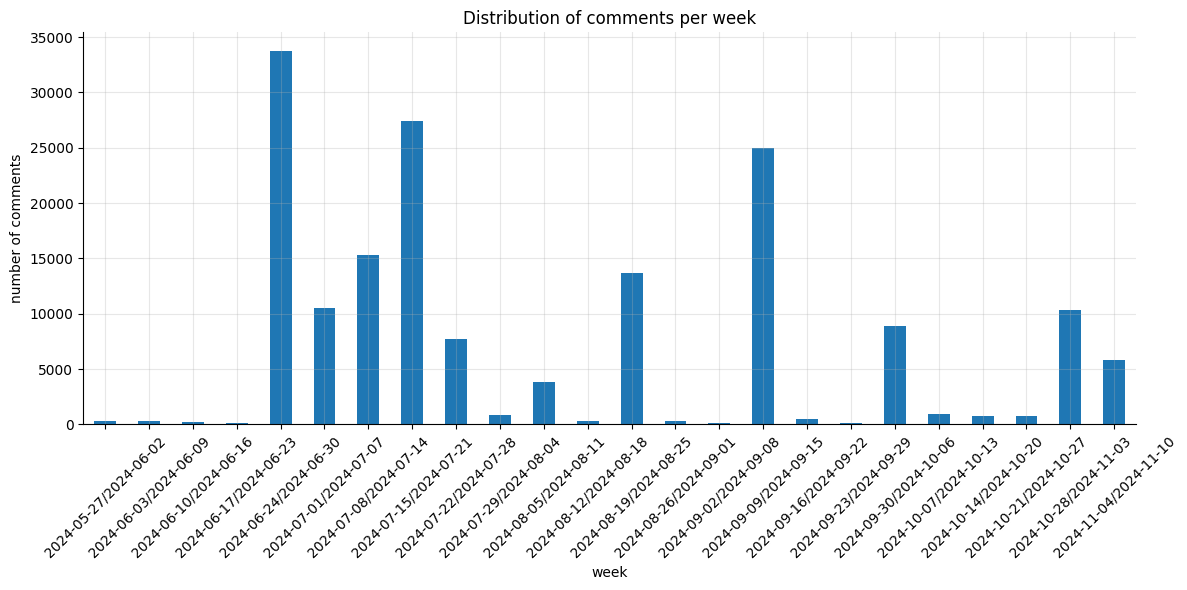

In [21]:
# plot distribution of comments per week
plt.figure(figsize=(12, 6))
comments['date_day'].dt.to_period('W').value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of comments per week')
plt.xlabel('week')
plt.ylabel('number of comments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
comments['week'] = comments['date_day'].dt.to_period('W')
sample_values = min(comments['week'].value_counts().sort_index())
sample_values

85

In [23]:
# from each week, get random sample of 85 comments
comments_sample = comments.groupby('week').apply(lambda x: x.sample(sample_values)).reset_index(drop=True)
comments_sample = comments_sample.sort_values(by='datetime')
comments_sample

,subreddit,post_id,id,parent,datetime,score,upvotes,body,date_day,week
10,Conservative,t3_1d5a3gj,t1_l6k1hid,t3_1d5a3gj,2024-06-01 02:26:00,3,3,"Bragg a commie? Nah, he's just a sycophant who...",2024-06-01,2024-05-27/2024-06-02
25,Conservative,t3_1d5bq7s,t1_l6kbzl1,t1_l6kbt1y,2024-06-01 03:42:36,15,15,trumps wasnt a campaign expense.,2024-06-01,2024-05-27/2024-06-02
26,Conservative,t3_1d5cxhf,t1_l6km7ml,t3_1d5cxhf,2024-06-01 05:01:12,7,7,Trump's problem is he spent most of his life r...,2024-06-01,2024-05-27/2024-06-02
81,Conservative,t3_1d5coqk,t1_l6kpgqc,t3_1d5coqk,2024-06-01 05:27:58,6,6,I’ve been a poll worker and a challenger in va...,2024-06-01,2024-05-27/2024-06-02
38,politics,t3_1d5ov0s,t1_l6mt4yv,t3_1d5ov0s,2024-06-01 17:02:38,45,45,Ann Telnaes\n \n[Justice Alito responds to his...,2024-06-01,2024-05-27/2024-06-02
...,...,...,...,...,...,...,...,...,...,...
2005,politics,t3_1gjdfxd,t1_lvfmccs,t1_lvflhmi,2024-11-05 00:27:08,6,6,"It won't go away instantly, but it *will* go a...",2024-11-05,2024-11-04/2024-11-10
1984,politics,t3_1gjdfxd,t1_lvfnmxh,t1_lvfkxqd,2024-11-05 00:34:16,1,1,"If pre-Holly, tell him that as a minority of w...",2024-11-05,2024-11-04/2024-11-10
2034,politics,t3_1gjdfxd,t1_lvfo3hc,t1_lvfns37,2024-11-05 00:36:52,9,9,They are still fucking doing that?? They are j...,2024-11-05,2024-11-04/2024-11-10
1965,politics,t3_1gjdfxd,t1_lvfppmx,t1_lvfpirx,2024-11-05 00:45:51,8,8,I mean he won’t concede and do a bunch of bull...,2024-11-05,2024-11-04/2024-11-10


#### Biweekly

In [24]:
# read csv
comments = pd.read_csv('../data/processed/comments.csv')
# sort by date
comments = comments.sort_values(by='datetime')
# drop rows with missing values
comments = comments.dropna()
comments = comments.reset_index(drop=True)
comments['date_day'] = pd.to_datetime(comments['date_day'])

comments

,subreddit,post_id,id,parent,datetime,score,upvotes,body,date_day
0,Conservative,t3_1d5a3gj,t1_l6k1hid,t3_1d5a3gj,2024-06-01 02:26:00,3,3,"Bragg a commie? Nah, he's just a sycophant who...",2024-06-01
1,Conservative,t3_1d5bq7s,t1_l6kbzl1,t1_l6kbt1y,2024-06-01 03:42:36,15,15,trumps wasnt a campaign expense.,2024-06-01
2,Conservative,t3_1d5a3gj,t1_l6kkzwp,t3_1d5a3gj,2024-06-01 04:51:33,-5,-5,Crime rate plummets. Trump goes to jail. Anoth...,2024-06-01
3,Conservative,t3_1d5cxhf,t1_l6km7ml,t3_1d5cxhf,2024-06-01 05:01:12,7,7,Trump's problem is he spent most of his life r...,2024-06-01
4,Conservative,t3_1d5coqk,t1_l6kpgqc,t3_1d5coqk,2024-06-01 05:27:58,6,6,I’ve been a poll worker and a challenger in va...,2024-06-01
...,...,...,...,...,...,...,...,...,...
167794,politics,t3_1gjdfxd,t1_lvfrzmk,t1_lvfrjhp,2024-11-05 00:58:37,7,7,"Trump up 4 points in Maryland!\n\n(""See? That ...",2024-11-05
167795,politics,t3_1gjdfxd,t1_lvfs1gu,t3_1gjdfxd,2024-11-05 00:58:54,12,12,"At this point the only states im ""worried"" abo...",2024-11-05
167796,politics,t3_1gjdfxd,t1_lvfs1k6,t1_lvfre42,2024-11-05 00:58:55,-5,-5,He's been saying the same script for the past ...,2024-11-05
167797,Conservative,t3_1gjrpbw,t1_lvfs3rk,t1_lvfqjvl,2024-11-05 00:59:17,49,49,This is the same county that the court case fo...,2024-11-05


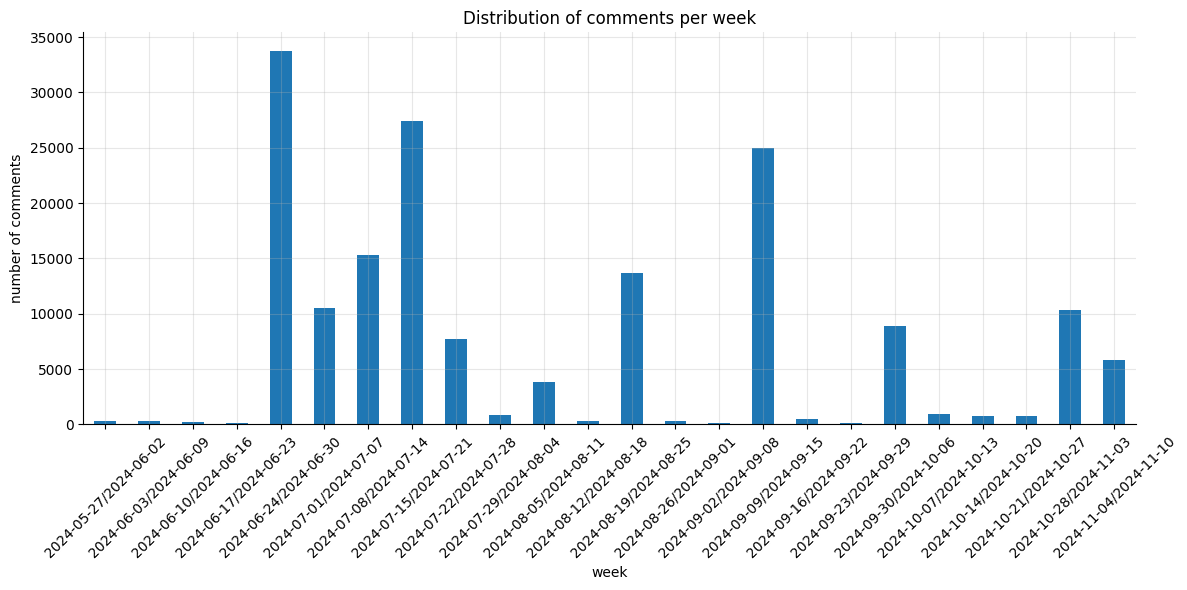

In [25]:
plt.figure(figsize=(12, 6))
comments['date_day'].dt.to_period('W').value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of comments per week')
plt.xlabel('week')
plt.ylabel('number of comments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [26]:
#make the column date_day the index
biweekly_comments = comments.set_index('date_day', inplace=False)
sample_values = min(biweekly_comments.groupby(pd.Grouper(freq='2W'))['body'].count().sort_index())
sample_values

327

In [27]:
comments_sample = biweekly_comments.groupby(pd.Grouper(freq='2W')).apply(lambda x: x.sample(sample_values)).reset_index(drop=True)
comments_sample = comments_sample.sort_values(by='datetime')
comments_sample['datetime'] = pd.to_datetime(comments_sample['datetime'])
comments_sample

,subreddit,post_id,id,parent,datetime,score,upvotes,body
83,Conservative,t3_1d5a3gj,t1_l6k1hid,t3_1d5a3gj,2024-06-01 02:26:00,3,3,"Bragg a commie? Nah, he's just a sycophant who..."
248,Conservative,t3_1d5bq7s,t1_l6kbzl1,t1_l6kbt1y,2024-06-01 03:42:36,15,15,trumps wasnt a campaign expense.
192,Conservative,t3_1d5a3gj,t1_l6kkzwp,t3_1d5a3gj,2024-06-01 04:51:33,-5,-5,Crime rate plummets. Trump goes to jail. Anoth...
310,Conservative,t3_1d5cxhf,t1_l6km7ml,t3_1d5cxhf,2024-06-01 05:01:12,7,7,Trump's problem is he spent most of his life r...
124,Conservative,t3_1d5coqk,t1_l6kpgqc,t3_1d5coqk,2024-06-01 05:27:58,6,6,I’ve been a poll worker and a challenger in va...
...,...,...,...,...,...,...,...,...
3962,politics,t3_1gjdfxd,t1_lvfnywg,t1_lvflhmi,2024-11-05 00:36:08,2,2,"Yeah, this is the only silver lining for me. I..."
4199,politics,t3_1gjdfxd,t1_lvfo3hc,t1_lvfns37,2024-11-05 00:36:52,9,9,They are still fucking doing that?? They are j...
4111,politics,t3_1gjdfxd,t1_lvfqtoz,t1_lvfo8dl,2024-11-05 00:52:01,2,2,Someone else post in here a few minutes ago fr...
4249,politics,t3_1gjdfxd,t1_lvfqzx8,t1_lvfov95,2024-11-05 00:53:00,1,1,Watch this primer from Kamala’s team \n\n


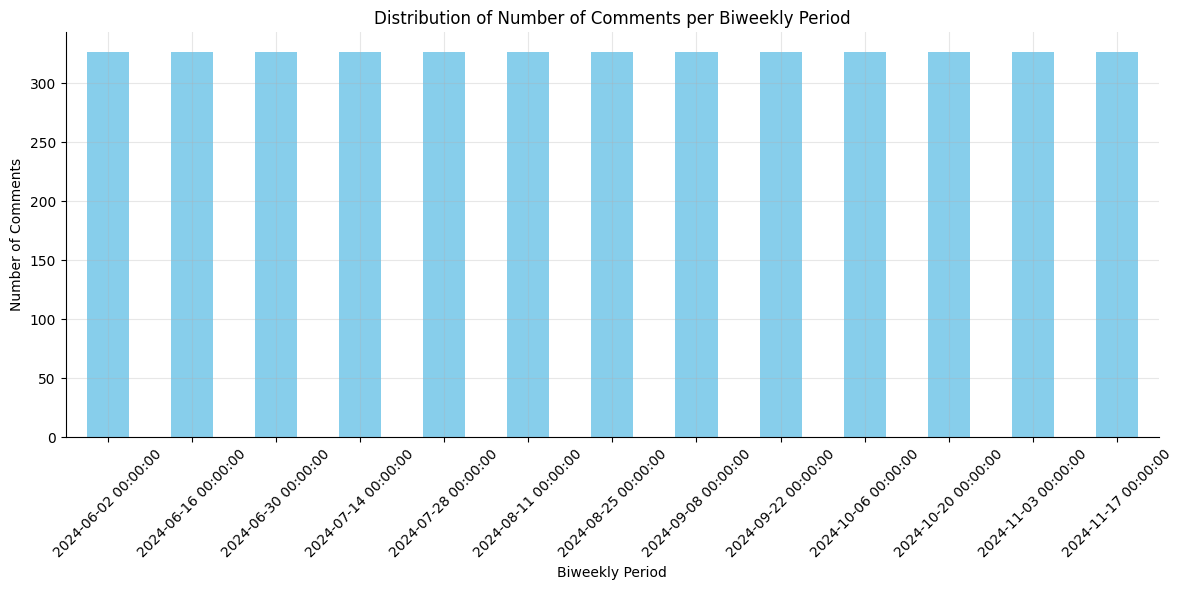

In [28]:
# Group by biweekly periods and count the number of comments in each period
biweekly_counts = comments_sample.set_index('datetime', inplace=False).groupby(pd.Grouper( freq='2W')).size()

# Plotting the distribution
plt.figure(figsize=(12, 6))
biweekly_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Number of Comments per Biweekly Period')
plt.xlabel('Biweekly Period')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### modeling

In [29]:
def preprocess_text(text):
    """
    Preprocess text for topic modeling.
    """
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # lowercase
    text = text.lower()

    # delete special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # tokenize
    tokens = word_tokenize(text)

    # delete stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens
             if token not in stop_words and len(token) > 2]

    return tokens


# Aplicar preprocesamiento
comments_sample['processed_text'] = comments_sample['body'].swifter.apply(preprocess_text)

# Verificar el preprocesamiento
print("\nResults:")
print("Original:", comments_sample['body'].iloc[0])
print("Processed:", comments_sample['processed_text'].iloc[0])

Pandas Apply: 100%|██████████| 4251/4251 [00:01<00:00, 2506.74it/s]


Results:
Original: Bragg a commie? Nah, he's just a sycophant who will go along with whatever the Jackass party wants him to say. Biden says "Convict his political rival", Bragg says "For how long?".
Processed: ['bragg', 'commie', 'nah', 'he', 'sycophant', 'along', 'whatever', 'jackass', 'party', 'want', 'say', 'biden', 'say', 'convict', 'political', 'rival', 'bragg', 'say', 'long']


In [30]:
# create dictionary
dictionary = Dictionary(comments_sample['processed_text'])

# filter extremes
dictionary.filter_extremes(no_below=5, no_above=0.5)
print("\nVocabulary size:", len(dictionary))

# create corpus
corpus = [dictionary.doc2bow(doc) for doc in comments_sample['processed_text']]

# prepare time slices
# for weekly periods
# time_slices = comments_sample.groupby('week').size().tolist()

# for biweekly periods
time_slices = comments_sample.set_index('datetime', inplace=False).groupby(pd.Grouper( freq='2W')).size().tolist()


print("\nNumber of time periods:", len(time_slices))



Vocabulary size: 2636

Number of time periods: 13


In [ ]:
from sklearn.model_selection import ParameterGrid
import tqdm
from gensim.models.coherencemodel import CoherenceModel

best_score = -np.inf  # Or use a different evaluation metric
best_params = None

# Generate all combinations of parameters
param_grid = {
    'num_topics': [3, 4, 5],
    'chain_variance': [0.01, 0.1],
    'passes': [5],
    'alpha': [0.1, 0.5, 'auto'],
    'eta': [0.1, 0.5, 'auto']
}

grid = ParameterGrid(param_grid)

# Loop over all parameter combinations
for params in tqdm.tqdm(grid):
    model = LdaSeqModel(
        corpus=corpus,
        time_slice=time_slices,
        id2word=dictionary,
        chain_variance=params['chain_variance'],
        passes=params['passes'],
        lda_model=LdaModel(
            corpus=corpus,
            num_topics=params['num_topics'],
            alpha=params['alpha'],
            eta=params['eta'],
            id2word=dictionary
        )
    )
    
    coherence_scores = []
    # Evaluate the model, e.g., using perplexity or coherence score
    for t in range(len(time_slices)):  # Loop through time periods
        coherence = CoherenceModel(topics = model.dtm_coherence(time=t), corpus=corpus, dictionary=dictionary, coherence='u_mass').get_coherence()
        coherence_scores.append(coherence)
    score = np.mean(coherence_scores)
    
    # Track the best model
    if score > best_score:
        best_score = score
        best_params = params
        print("Best score:", best_score)
        print("Best parameters:", best_params)

# After the loop, best_params will hold the optimal parameters
print('FINISHED')
print("Best score:", best_score)
print("Best parameters:", best_params)


# Best parameters: {'alpha': 0.5, 'chain_variance': 0.01, 'eta': 0.5, 'num_topics': 5, 'passes': 5}

  2%|▏         | 1/54 [37:55<33:29:38, 2275.07s/it]

Best score: -2.719388039246285
Best parameters: {'alpha': 0.1, 'chain_variance': 0.01, 'eta': 0.1, 'num_topics': 3, 'passes': 5}


  6%|▌         | 3/54 [1:31:42<24:56:54, 1761.06s/it]

Best score: -2.6817740039838136
Best parameters: {'alpha': 0.1, 'chain_variance': 0.01, 'eta': 0.1, 'num_topics': 5, 'passes': 5}


 44%|████▍     | 24/54 [10:41:00<13:21:21, 1602.73s/it]

Best score: -2.6814786118113694
Best parameters: {'alpha': 0.5, 'chain_variance': 0.01, 'eta': 0.5, 'num_topics': 5, 'passes': 5}


 46%|████▋     | 25/54 [11:29:26<13:19:44, 1654.65s/it]


KeyboardInterrupt: 

In [31]:
from gensim.models.ldamodel import LdaModel

best_params = {'alpha': 'auto', 'chain_variance': 0.05, 'eta': 'auto', 'num_topics': 4, 'passes': 5}

dtm = LdaSeqModel(
    corpus=corpus,
    time_slice=time_slices,
    num_topics=best_params['num_topics'],
    id2word=dictionary,
    chain_variance=best_params['chain_variance'],
    passes=best_params['passes'],
    lda_model=LdaModel(
        corpus=corpus,
        num_topics=best_params['num_topics'],
        alpha=best_params['alpha'],
        eta=best_params['eta'],
        id2word=dictionary
    )
)

In [32]:
def print_topic_evolution(model, periods=None):
    """
    print the evolution of topics over time
    """
    num_time_slices = len(time_slices)
    for t in range(num_time_slices):
        print(f"\nPeriod {t}:")
        for topic in range(model.num_topics):
            top_terms = model.print_topics(time=t)[topic]
            print(f"Topic {topic}: {top_terms[:5]}")

# show topic evolution
print_topic_evolution(dtm)


Period 0:
Topic 0: [('biden', 0.016235195810053366), ('like', 0.00886427602495216), ('campaign', 0.008353201593316848), ('crime', 0.008209295523310126), ('year', 0.006969462114542488)]
Topic 1: [('like', 0.016730303233838634), ('paxton', 0.011149498369119402), ('conservative', 0.010444093088537587), ('people', 0.009458208559763903), ('would', 0.00877293938877429)]
Topic 2: [('law', 0.015138322584230453), ('crime', 0.013281834358853413), ('judge', 0.01128118726850925), ('get', 0.01013973738805522), ('would', 0.009386762150917797)]
Topic 3: [('biden', 0.03587836101515001), ('vote', 0.02516044298362795), ('candidate', 0.014864923407556772), ('like', 0.014252727207773649), ('voting', 0.013561391627058552)]

Period 1:
Topic 0: [('biden', 0.033024395638905905), ('year', 0.008813097641140804), ('like', 0.00860149844927867), ('think', 0.00797284226140927), ('he', 0.007068507466133006)]
Topic 1: [('paxton', 0.019988647248362832), ('like', 0.013202041876684483), ('would', 0.00998815483278076), 

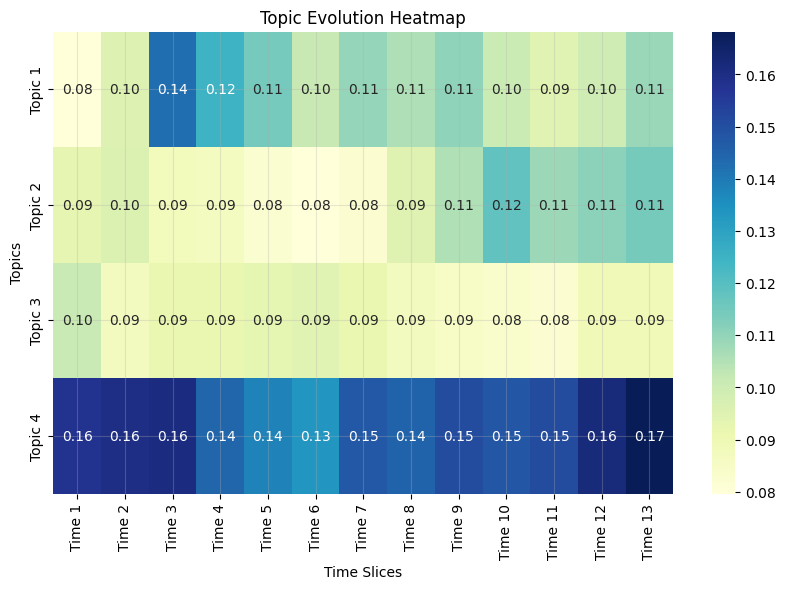

In [35]:
def get_topic_word_distributions(model, num_topics, time_slices, top_n=10):
    """
    Get the top words for each topic at each time slice.
    """
    # Initialize an array to store topic word distributions
    topic_evolution = np.zeros((num_topics, time_slices))

    # Iterate over each time slice and extract the topic-word distributions
    for t in range(time_slices):
        for topic in range(num_topics):
            # Get the top words for the topic at the current time slice
            top_terms = model.print_topics(time=t)[topic][:top_n]
            
            # Calculate the total weight of the topic's top words for this time slice
            total_weight = sum(weight for _, weight in top_terms)
            topic_evolution[topic, t] += total_weight
    
    return topic_evolution

# Assuming dtm is your trained LdaSeqModel
num_topics = 4  # Number of topics  

# Get the topic evolution over time
topic_evolution = get_topic_word_distributions(dtm, num_topics, len(time_slices))

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(topic_evolution, cmap="YlGnBu", cbar=True, annot=True, fmt=".2f",
            xticklabels=[f'Time {i+1}' for i in range(len(time_slices))],
            yticklabels=[f'Topic {i+1}' for i in range(num_topics)])
plt.title("Topic Evolution Heatmap")
plt.xlabel("Time Slices")
plt.ylabel("Topics")
plt.show()

In [36]:
# save model
dtm.save('dtm_model_4topics_0_100chanin_biweekly')

# export topics evolution
topics_over_time = {}
num_time_slices = len(time_slices)

for t in range(num_time_slices):
    # obtain topics
    topics = dtm.print_topics(time=t)

    # save topics
    period_topics = {}
    for topic_id, topic_terms in enumerate(topics):
        period_topics[f'Topic_{topic_id}'] = topic_terms[:5] 

    topics_over_time[t] = period_topics

# dataframe
topics_df = pd.DataFrame.from_dict(topics_over_time, orient='index')

# save to csv
topics_df.to_csv('../data/mining/model_4topics_0_100chanin_biweekly.csv')


In [ ]:
# model = LdaSeqModel.load('dtm_model_5topics_0_100chanin_biweekly')

# Time series: Support score analysis

In [2]:
df_trump_biden = pd.read_csv('../data/processed/final_dataset_trump_biden.csv')
df_trump_harris = pd.read_csv('../data/processed/final_dataset_trump_harris.csv')

In [3]:
df_trump_harris.head()

,date_day,polls_Trump,polls_Harris,google_Harris,google_Trump,donald_trump_love,donald_trump_hate,kamala_harris_love,kamala_harris_hate
0,2024-07-24,0.440377,0.448710,0.105,0.075,0.352375,0.647625,0.486752,0.513248
1,2024-07-25,0.442427,0.446329,0.115,0.065,0.350676,0.649324,0.558862,0.441138
2,2024-07-26,0.440460,0.437328,0.085,0.060,0.367760,0.632240,0.428942,0.571058
3,2024-07-27,0.440216,0.437453,0.060,0.070,0.378309,0.621691,0.457191,0.542809
4,2024-07-28,0.441076,0.438446,0.050,0.070,0.293569,0.706431,0.378350,0.621650


In [4]:
df_love_trump_biden = df_trump_biden[['date_day','donald_trump_love', 'joe_biden_love']]
df_love_trump_harris = df_trump_harris[['date_day','donald_trump_love', 'kamala_harris_love']]

df_love_trump_biden.set_index('date_day', inplace=True)
df_love_trump_harris.set_index('date_day', inplace=True)

# convert to datetime
df_love_trump_biden.index = pd.to_datetime(df_love_trump_biden.index)
df_love_trump_harris.index = pd.to_datetime(df_love_trump_harris.index)

df_love_trump_biden.asfreq('D')
df_love_trump_harris.asfreq('D')


,donald_trump_love,kamala_harris_love
date_day,,
2024-07-24,0.352375,0.486752
2024-07-25,0.350676,0.558862
2024-07-26,0.367760,0.428942
2024-07-27,0.378309,0.457191
2024-07-28,0.293569,0.378350
...,...,...
2024-11-01,0.353853,0.551061
2024-11-02,0.344661,0.571459
2024-11-03,0.347723,0.582334


## Trump, Biden

In [5]:
trump_love = df_love_trump_biden['donald_trump_love']
biden_love = df_love_trump_biden['joe_biden_love']

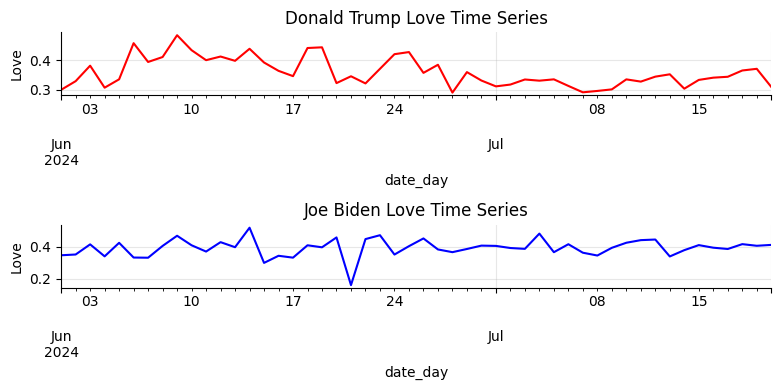

In [6]:
# make 2 subplots for trump and biden love time series
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(8, 4))
trump_love.plot(ax=ax[0], color='red')
ax[0].set_title('Donald Trump Love Time Series')
ax[0].set_ylabel('Love')
biden_love.plot(ax=ax[1], color='blue')
ax[1].set_title('Joe Biden Love Time Series')
ax[1].set_ylabel('Love')
plt.tight_layout()
plt.show()


### Dickie-Fuller test

In [7]:
# Perform Dickie-Fuller test for stationarity on both time series
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # Perform Dickie-Fuller test:
    print('Results of Dickie-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
print('Trump Love Time Series:')
test_stationarity(trump_love)
print()
print('Biden Love Time Series:')
test_stationarity(biden_love)

Trump Love Time Series:
Results of Dickie-Fuller Test:
Test Statistic                 -3.776781
p-value                         0.003154
#Lags Used                      0.000000
Number of Observations Used    49.000000
Critical Value (1%)            -3.571472
Critical Value (5%)            -2.922629
Critical Value (10%)           -2.599336
dtype: float64

Biden Love Time Series:
Results of Dickie-Fuller Test:
Test Statistic                -6.594023e+00
p-value                        6.998457e-09
#Lags Used                     1.000000e+00
Number of Observations Used    4.800000e+01
Critical Value (1%)           -3.574589e+00
Critical Value (5%)           -2.923954e+00
Critical Value (10%)          -2.600039e+00
dtype: float64


**Trump Love Time Series**

Test Statistic: -3.776781
p-value: 0.003154
Critical Values:
1%: -3.571472
5%: -2.922629
10%: -2.599336

Interpretation:
- The test statistic (-3.776781) is lower than all the critical values (1%, 5%, and 10%).
- The p-value (0.003154) is significantly less than 0.05, which means we reject the null hypothesis.

**Conclusion: The series is stationary.**

**Biden Love Time Series**

Test Statistic: -6.594023
p-value: 6.998457e-09 (~0.000000007)
Critical Values:
1%: -3.574589
5%: -2.923954
10%: -2.600039

Interpretation:
The test statistic (-6.594023) is much lower than all the critical values.
The p-value (~0.000000007) is extremely small, allowing us to confidently reject the null hypothesis.

**Conclusion: The series is stationary.**

Train-test split: 90-10

In [8]:

train_size = int(len(trump_love) * 0.9)  
trump_love_train = trump_love.iloc[:train_size]   
trump_love_test = trump_love.iloc[train_size:]     
biden_love_train = biden_love.iloc[:train_size]   
biden_love_test = biden_love.iloc[train_size:]    

### ACF

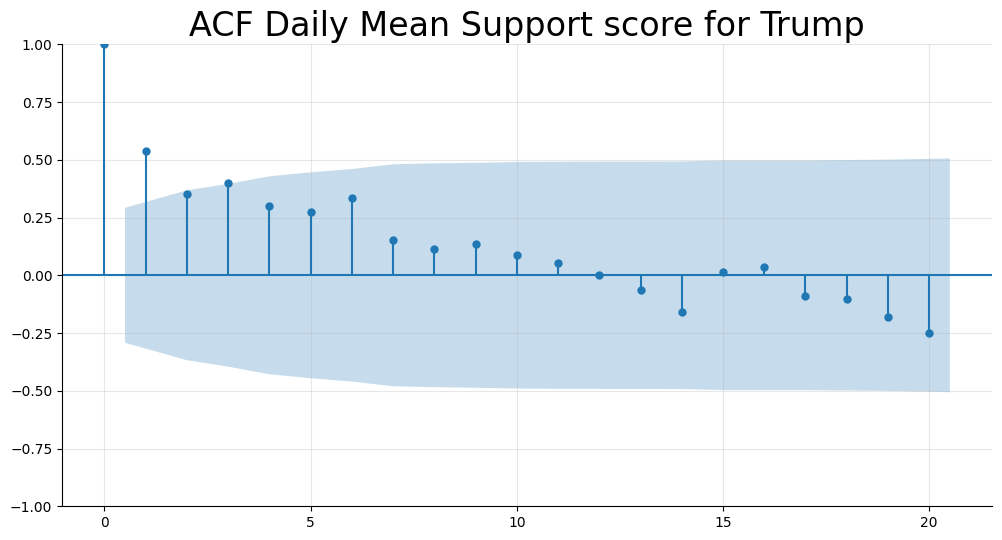

In [9]:
sgt.plot_acf(trump_love_train, lags = 20, zero = True)
plt.title("ACF Daily Mean Support score for Trump", size = 24)
plt.show()

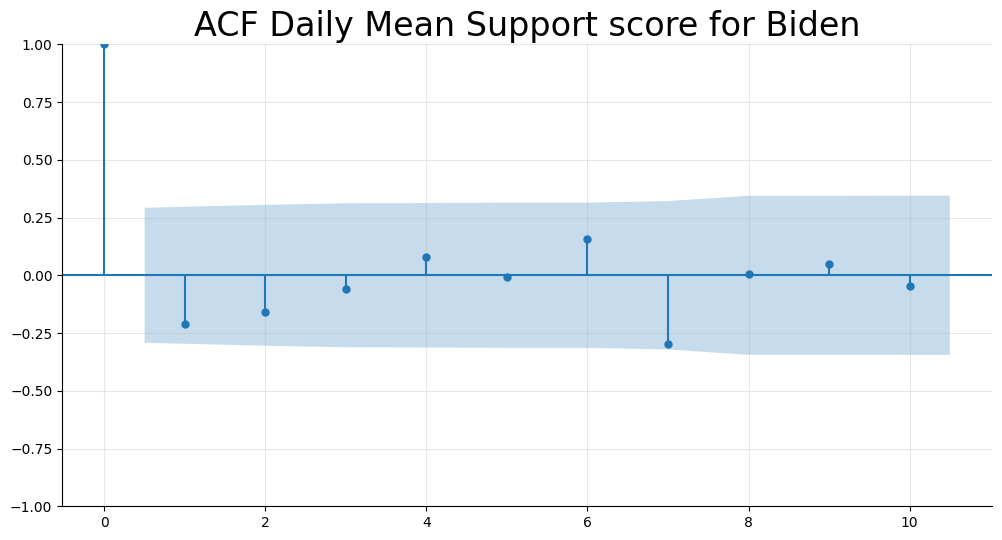

In [10]:
sgt.plot_acf(biden_love_train, lags = 10, zero = True)
plt.title("ACF Daily Mean Support score for Biden", size = 24)
plt.show()

### PACF

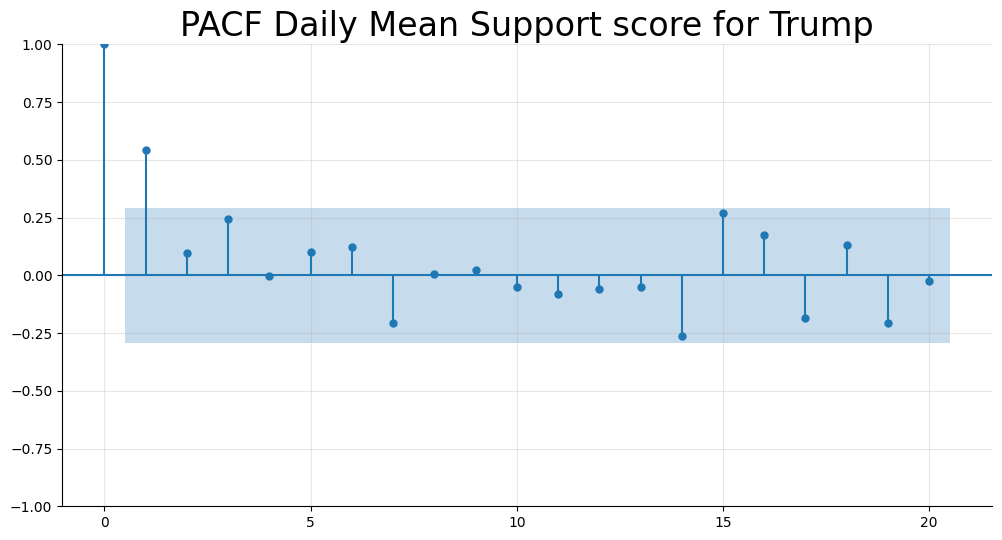

In [11]:
sgt.plot_pacf(trump_love_train, lags = 20, zero = True, method = ('ols'))
plt.title("PACF Daily Mean Support score for Trump", size = 24)
plt.show()

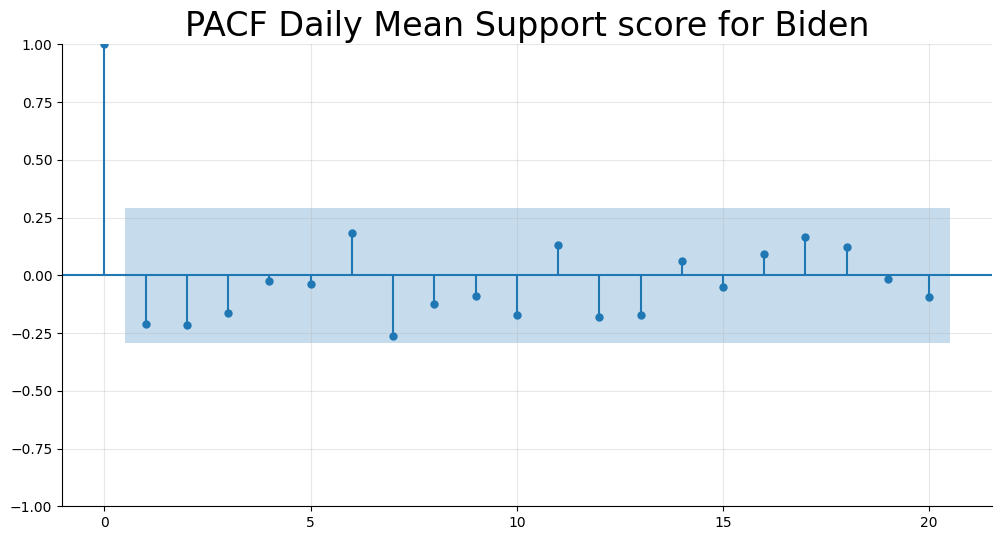

In [12]:
sgt.plot_pacf(biden_love_train, lags = 20, zero = True, method = ('ols'))
plt.title("PACF Daily Mean Support score for Biden", size = 24)
plt.show()

### Conclusion

Trump Love Time Series:
- The ACF plot shows an incremental decrease in the autocorrelation values, which is a sign of a stationary series, also telling us that an AR model would be a good fit, with a p value from 2-5.
- The PACF plot shows a sharp decrease after the first lag, which is another sign of a stationary series, also telling us that an MA model would be a good fit, with a q value between 1-2.

Biden Love Time Series:
- The ACF plot shows a huge peak on 0, then a sahrph decrease, with all following values being within the confidence interval, which is a sign of a stationary series, also telling us that an AR model would be a good fit, with a p value of 0, 1 at most.
- The PACF plot shows the same pattern as the ACF plot, which is another sign of a stationary series, also telling us that an MA model would be a good fit, with a q value of 1.

### ARMA

We then use pdarima to find the best ARMA model for each time series, and see if it fits with our observations of the acf and pacf plots.

Trump arma

In [13]:
trump_arima = pm.auto_arima(trump_love_train, seasonal = False, stationary=True, stepwise = False, suppress_warnings = True, error_action = "ignore", trace = True,
                            start_p=0, start_q=0, max_p=10, max_q=10, n_fits=1000, max_order=None, information_criterion='bic')
trump_arima.summary()


 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=-133.624, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=-142.482, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : BIC=-139.588, Time=0.02 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : BIC=-138.109, Time=0.04 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : BIC=-135.603, Time=0.06 sec
 ARIMA(0,0,5)(0,0,0)[0] intercept   : BIC=-131.806, Time=0.10 sec
 ARIMA(0,0,6)(0,0,0)[0] intercept   : BIC=-133.559, Time=0.09 sec
 ARIMA(0,0,7)(0,0,0)[0] intercept   : BIC=inf, Time=0.08 sec
 ARIMA(0,0,8)(0,0,0)[0] intercept   : BIC=-129.399, Time=0.13 sec
 ARIMA(0,0,9)(0,0,0)[0] intercept   : BIC=-129.583, Time=0.17 sec
 ARIMA(0,0,10)(0,0,0)[0] intercept   : BIC=inf, Time=0.36 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=-145.753, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=-143.433, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : BIC=-140.571, Time=0.04 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : BIC=-137.612, Time=0.05 sec
 ARIMA(1,0,4)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   45
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  78.587
Date:                Mon, 09 Dec 2024   AIC                           -151.173
Time:                        17:19:20   BIC                           -145.753
Sample:                    06-01-2024   HQIC                          -149.153
                         - 07-15-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1613      0.061      2.660      0.008       0.042       0.280
ar.L1          0.5510      0.160      3.439      0.001       0.237       0.865
sigma2         0.0018      0.000      4.682      0.000       0.001       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 1.99
Prob(Q):                              0.68   Prob(JB):                         0.37
Heteroskedasticity (H):               0.24   Skew:                             0.48
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Biden arma

In [17]:
biden_arima = pm.auto_arima(biden_love_train, seasonal = False, stationary=True, stepwise = True, suppress_warnings = True, error_action = "ignore", trace = True,
                            start_p=0, start_q=0, max_p=None, max_q=None, n_fits=1000, max_order=None, information_criterion='bic')

biden_arima.summary()


Performing stepwise search to minimize bic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=-120.805, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=-119.053, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=-120.609, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=48.291, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=-113.954, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.066 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   45
Model:                        SARIMAX   Log Likelihood                  64.209
Date:                Mon, 09 Dec 2024   AIC                           -124.419
Time:                        17:20:15   BIC                           -120.805
Sample:                    06-01-2024   HQIC                          -123.072
                         - 07-15-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3924      0.010     40.577      0.000       0.373       0.411
sigma2         0.0034      0.000      7.271      0.000       0.002       0.004
===================================================================================
Ljung-Box (L1) (Q):                   2.16   Jarque-Bera (JB):                36.66
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               0.47   Skew:                            -1.08
Prob(H) (two-sided):                  0.15   Kurtosis:                         6.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Forecasting

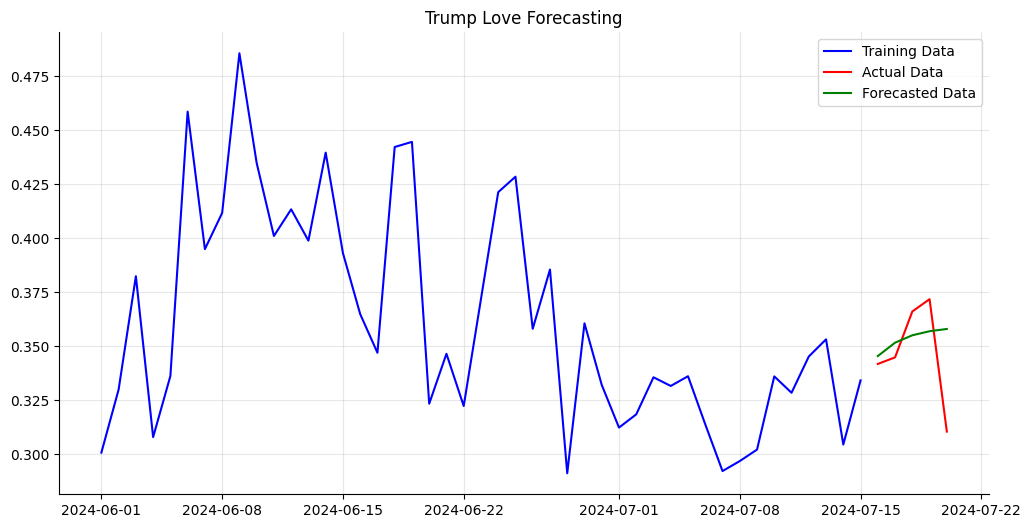

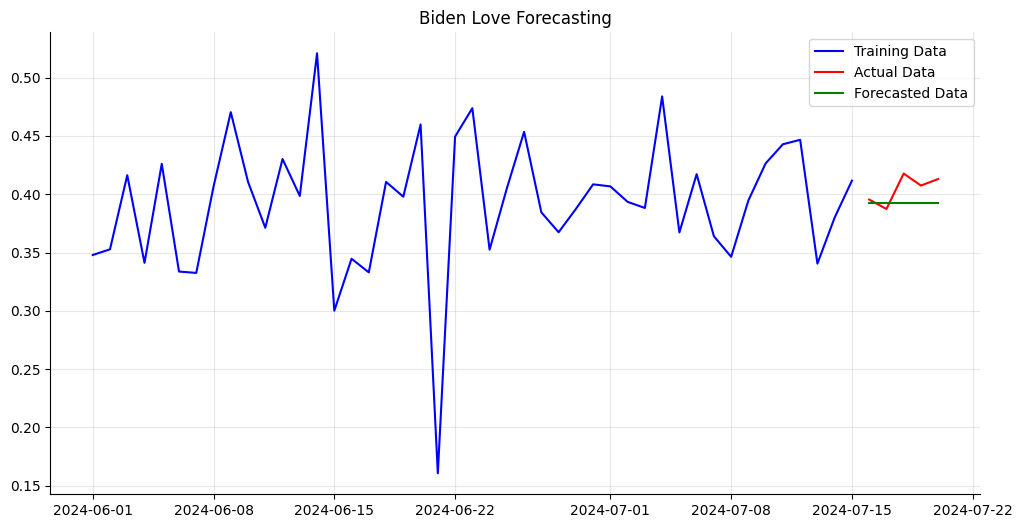

In [18]:
results_arma_trump_forecast = trump_arima.predict(n_periods=len(trump_love_test))
results_arma_biden_forecast = biden_arima.predict(n_periods=len(biden_love_test))

# Plot the forecasted values vs the actual test values
plt.figure(figsize=(12, 6))
plt.plot(trump_love_train, label='Training Data', color='blue')
plt.plot(trump_love_test, label='Actual Data', color='red')
plt.plot(results_arma_trump_forecast, label='Forecasted Data', color='green')
plt.title('Trump Love Forecasting')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(biden_love_train, label='Training Data', color='blue')
plt.plot(biden_love_test, label='Actual Data', color='red')
plt.plot(results_arma_biden_forecast, label='Forecasted Data', color='green')
plt.title('Biden Love Forecasting')
plt.legend()
plt.show()




The predictions are acceptable, AIC was the objective function used to find the best model, as it penalizes the number of parameters not as harshly as BIC, and it works best with smaller datasets.

### Conclusion
pdarima gave the expected parameters for the ARMA models, and the predictions were acceptable, given the small dataset and the apparent randomness of the data.

## Trump, Harris

In [48]:
trump_love = df_love_trump_harris['donald_trump_love']
harris_love = df_love_trump_harris['kamala_harris_love']


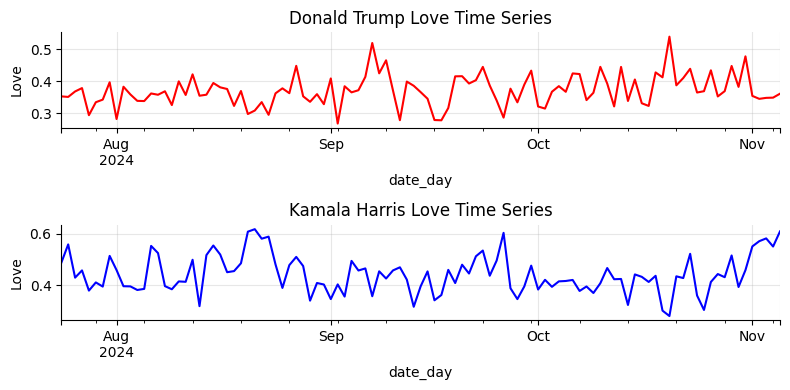

In [49]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(8, 4))
trump_love.plot(ax=ax[0], color='red')
ax[0].set_title('Donald Trump Love Time Series')
ax[0].set_ylabel('Love')
harris_love.plot(ax=ax[1], color='blue')
ax[1].set_title('Kamala Harris Love Time Series')
ax[1].set_ylabel('Love')
plt.tight_layout()


### Dickie-Fuller test

In [42]:
# Perform Dickie-Fuller test for stationarity on both time series
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # Perform Dickie-Fuller test:
    print('Results of Dickie-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
print('Trump Love Time Series:')
test_stationarity(trump_love)
print()
print('Harris Love Time Series:')
test_stationarity(harris_love)

Trump Love Time Series:
Results of Dickie-Fuller Test:
Test Statistic                -8.337694e+00
p-value                        3.238774e-13
#Lags Used                     0.000000e+00
Number of Observations Used    1.040000e+02
Critical Value (1%)           -3.494850e+00
Critical Value (5%)           -2.889758e+00
Critical Value (10%)          -2.581822e+00
dtype: float64

Harris Love Time Series:
Results of Dickie-Fuller Test:
Test Statistic                -6.062660e+00
p-value                        1.202221e-07
#Lags Used                     0.000000e+00
Number of Observations Used    1.040000e+02
Critical Value (1%)           -3.494850e+00
Critical Value (5%)           -2.889758e+00
Critical Value (10%)          -2.581822e+00
dtype: float64


**Trump Love Time Series:**

The test statistic is significantly lower than the critical values at all levels (1%, 5%, 10%), and the p-value is very small (far below 0.05). This suggests rejecting the null hypothesis of a unit root (non-stationarity), **this suggests that the Trump Love time series is stationary.**

**Harris Love Time Series:**

Similarly, the test statistic is significantly lower than the critical values, and the p-value is also very small, leading to the rejection of the null hypothesis, **indicating that the Harris Love time series is also stationary.**

Train-test split: 90-10

In [43]:
train_size = int(len(trump_love) * 0.9)  
trump_love_train = trump_love.iloc[:train_size]   
trump_love_test = trump_love.iloc[train_size:]     
harris_love_train = harris_love.iloc[:train_size]
harris_love_test = harris_love.iloc[train_size:]

### ACF

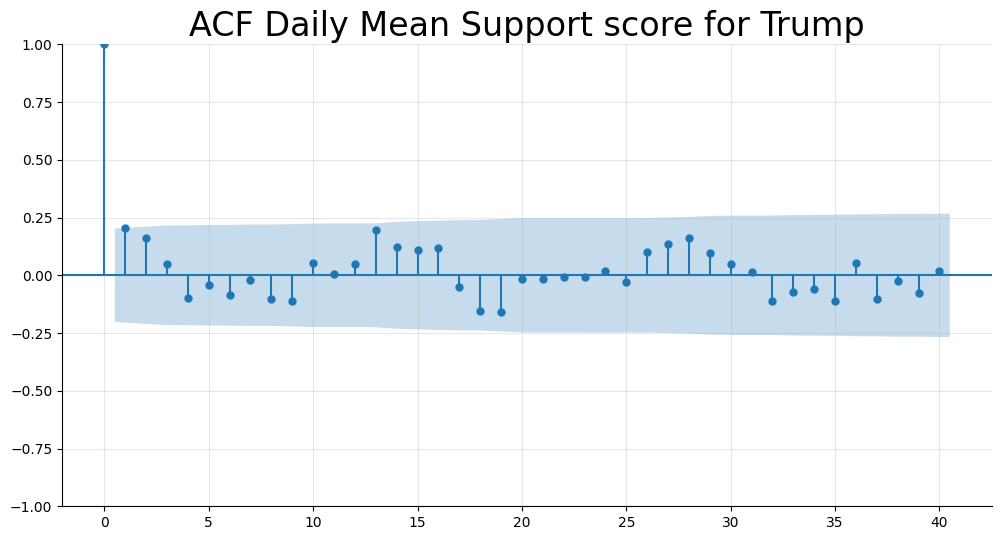

In [44]:
sgt.plot_acf(trump_love_train, lags = 40, zero = True)
plt.title("ACF Daily Mean Support score for Trump", size = 24)
plt.show()

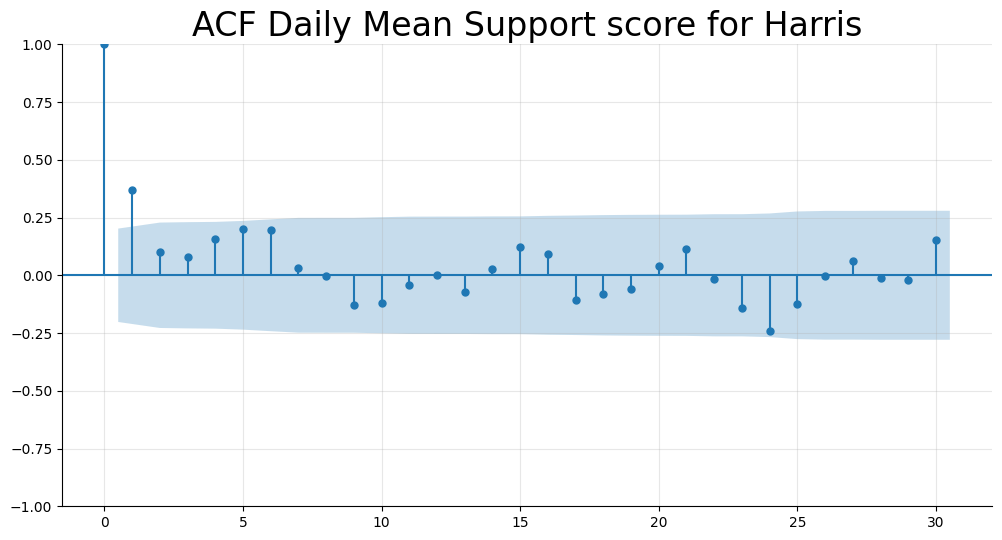

In [59]:
sgt.plot_acf(harris_love_train, lags = 30, zero = True)
plt.title("ACF Daily Mean Support score for Harris", size = 24)
plt.show()

### PACF

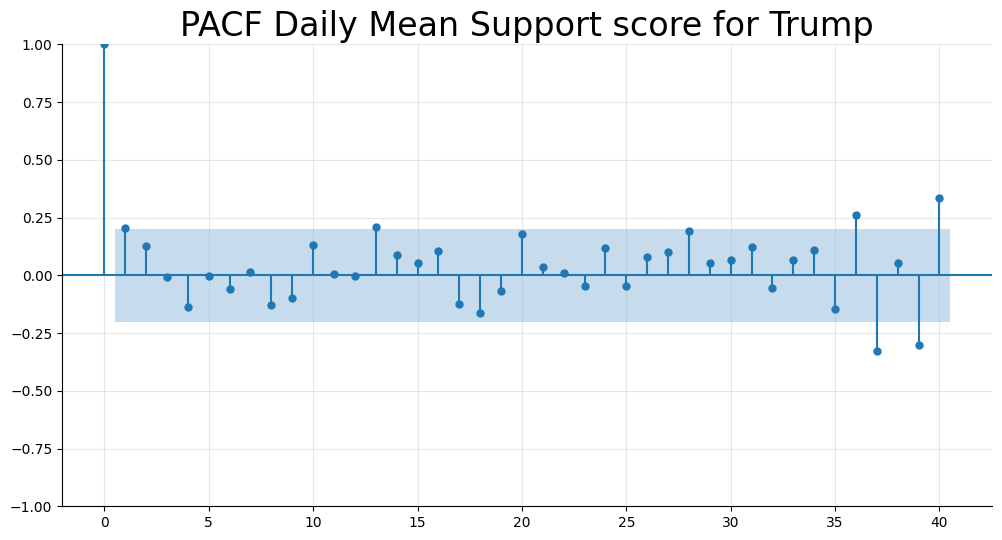

In [46]:
sgt.plot_pacf(trump_love_train, lags = 40, zero = True, method = ('ols'))
plt.title("PACF Daily Mean Support score for Trump", size = 24)
plt.show()

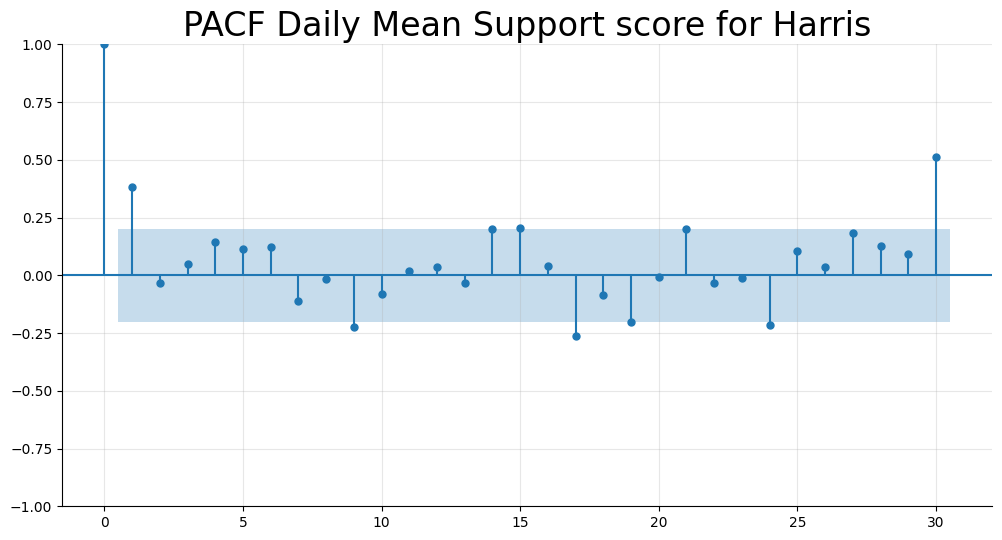

In [47]:
sgt.plot_pacf(harris_love_train, lags = 30, zero = True, method = ('ols'))
plt.title("PACF Daily Mean Support score for Harris", size = 24)
plt.show()

### Conclusion

Trump Love Time Series:
- The ACF plot shows a sharp decrease in the autocorrelation values, keeping the first lag outside the confidence interval, which is a sign of a stationary series, also telling us that an AR model would be a good fit, with a p value of 1.
- The PACF plot shows a sharp decrease after the first lag, which is another sign of a stationary series, also telling us that an MA component might not be necessary.

Harris Love Time Series:
- The ACF plot shows a huge peak on 0, then a sahrph decrease, keeping the first lag outside the confidence interval, with all following values being within the confidence interval, which is a sign of a stationary series, also telling us that an AR model would be a good fit, with a p value of 0 or 1.
- The PACF plot shows the same pattern as the ACF plot, which is another sign of a stationary series, also telling us that an MA component might not be necessary. Some other values are also outside the confidence interval, which might suggest a seasonal component.

### ARMA

Trump arma

In [50]:
trump_arima = pm.auto_arima(trump_love_train, seasonal = False, stationary=True, stepwise = False, suppress_warnings = True, error_action = "ignore", trace = True,
                            start_p=0, start_q=0, max_p=10, max_q=10, n_fits=1000, max_order=None)
trump_arima.summary()


 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-294.110, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-295.283, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-295.661, Time=0.02 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-294.504, Time=0.02 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=-293.274, Time=0.02 sec
 ARIMA(0,0,5)(0,0,0)[0] intercept   : AIC=-291.386, Time=0.06 sec
 ARIMA(0,0,6)(0,0,0)[0] intercept   : AIC=-289.540, Time=0.07 sec
 ARIMA(0,0,7)(0,0,0)[0] intercept   : AIC=-287.745, Time=0.12 sec
 ARIMA(0,0,8)(0,0,0)[0] intercept   : AIC=-286.290, Time=0.16 sec
 ARIMA(0,0,9)(0,0,0)[0] intercept   : AIC=-286.280, Time=0.20 sec
 ARIMA(0,0,10)(0,0,0)[0] intercept   : AIC=-284.314, Time=0.43 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-296.153, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-295.053, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-294.043, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-293.034, Time=0.10 sec
 ARIMA(1,

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   94
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 151.076
Date:                Wed, 20 Nov 2024   AIC                           -296.153
Time:                        10:10:11   BIC                           -288.523
Sample:                    07-24-2024   HQIC                          -293.071
                         - 10-25-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2932      0.046      6.373      0.000       0.203       0.383
ar.L1          0.2061      0.122      1.682      0.093      -0.034       0.446
sigma2         0.0024      0.000      7.377      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 4.93
Prob(Q):                              0.80   Prob(JB):                         0.09
Heteroskedasticity (H):               2.02   Skew:                             0.43
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Harris arma

Decompose the series to check for seasonality

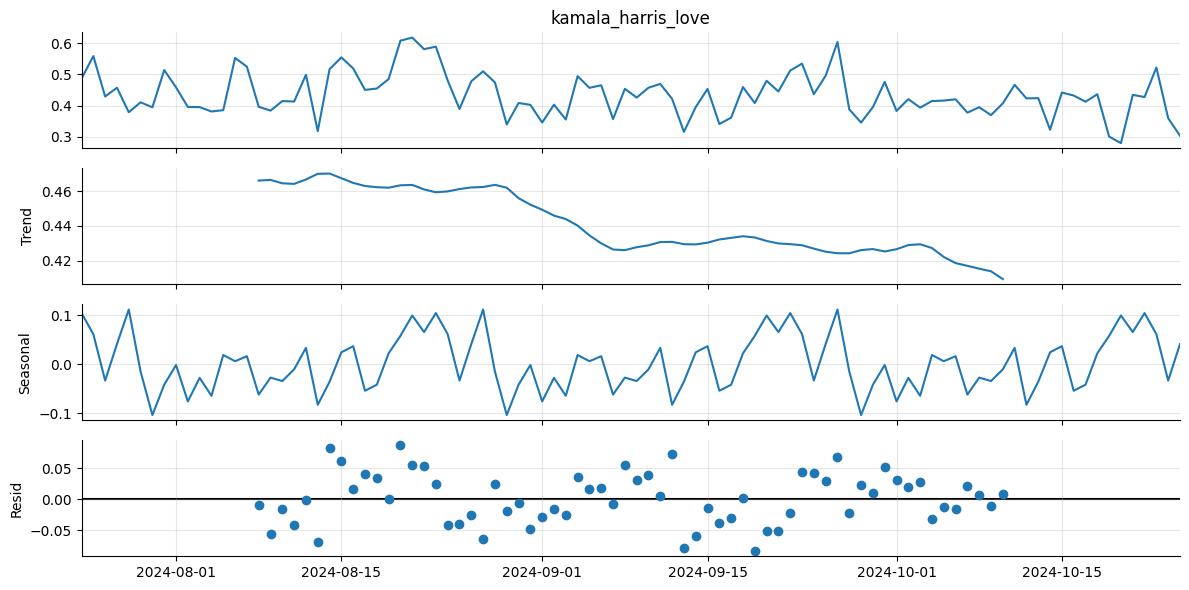

In [61]:
# decompose the time series to check for seasonality
from statsmodels.tsa.seasonal import seasonal_decompose

# do it on the harris love time series
result = seasonal_decompose(harris_love_train, model='additive', period=30)
result.plot()
plt.show()


Given the acf and pacf plots, we can see that in Harri's case, there might be a seasonal component, as decomposing with a frequency of 30 days shows small residuals, which seem to follow a pattern.

In [62]:
harris_arima = pm.auto_arima(harris_love_train, seasonal = True, m=30,
                             stationary=True, stepwise = True, suppress_warnings = True, error_action = "ignore", trace = True,
                            start_p=0, start_q=0, max_p=10, max_q=10, max_order=None, n_fits=1000)
harris_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[30] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[30] intercept   : AIC=-225.757, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[30] intercept   : AIC=-239.687, Time=0.79 sec
 ARIMA(0,0,1)(0,0,1)[30] intercept   : AIC=-238.855, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[30]             : AIC=114.908, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[30] intercept   : AIC=-238.075, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[30] intercept   : AIC=-238.935, Time=2.89 sec
 ARIMA(1,0,0)(1,0,1)[30] intercept   : AIC=-237.949, Time=0.73 sec
 ARIMA(1,0,0)(0,0,1)[30] intercept   : AIC=-240.721, Time=0.19 sec
 ARIMA(1,0,0)(0,0,2)[30] intercept   : AIC=-239.512, Time=1.43 sec
 ARIMA(1,0,0)(1,0,2)[30] intercept   : AIC=-237.416, Time=1.99 sec
 ARIMA(0,0,0)(0,0,1)[30] intercept   : AIC=-229.703, Time=0.35 sec
 ARIMA(2,0,0)(0,0,1)[30] intercept   : AIC=-238.738, Time=0.42 sec
 ARIMA(1,0,1)(0,0,1)[30] intercept   : AIC=-238.739, Time=0.31 sec
 ARIMA(2,0,1)(0,0,1)[30] 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   94
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 30)   Log Likelihood                 124.361
Date:                              Wed, 20 Nov 2024   AIC                           -240.721
Time:                                      10:17:53   BIC                           -230.548
Sample:                                  07-24-2024   HQIC                          -236.612
                                       - 10-25-2024                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2737      0.041      6.704      0.000       0.194       0.354
ar.L1          0.3707      0.089      4.185      0.000       0.197       0.544
ma.S.L30       0.3299      0.134      2.453      0.014       0.066       0.593
sigma2         0.0040      0.001      6.124      0.000       0.003       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.45
Prob(Q):                              0.98   Prob(JB):                         0.80
Heteroskedasticity (H):               0.78   Skew:                             0.05
Prob(H) (two-sided):                  0.49   Kurtosis:                         2.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Forecasting

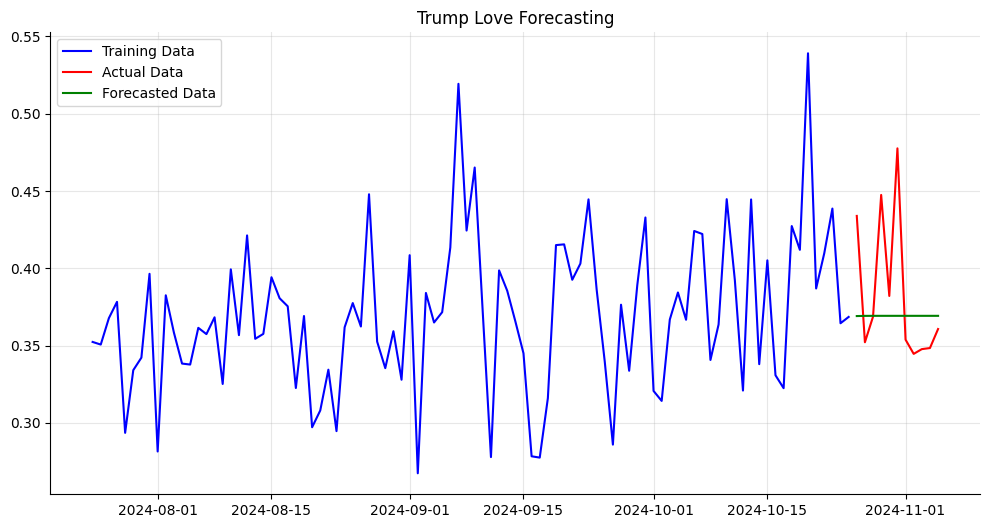

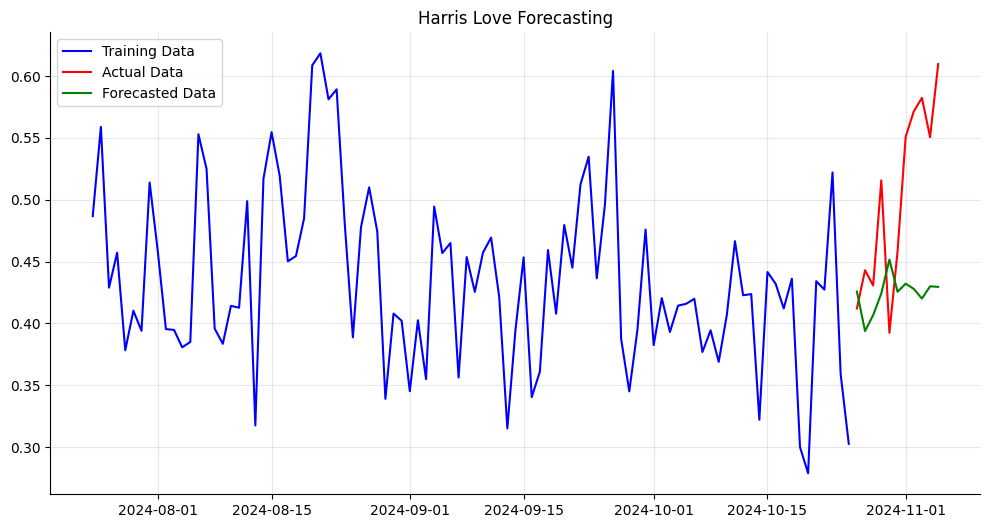

In [63]:
results_arma_trump_forecast = trump_arima.predict(n_periods=len(trump_love_test))
results_arma_harris_forecast = harris_arima.predict(n_periods=len(harris_love_test))

# Plot the forecasted values vs the actual test values
plt.figure(figsize=(12, 6))
plt.plot(trump_love_train, label='Training Data', color='blue')
plt.plot(trump_love_test, label='Actual Data', color='red')
plt.plot(results_arma_trump_forecast, label='Forecasted Data', color='green')
plt.title('Trump Love Forecasting')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(harris_love_train, label='Training Data', color='blue')
plt.plot(harris_love_test, label='Actual Data', color='red')
plt.plot(results_arma_harris_forecast, label='Forecasted Data', color='green')
plt.title('Harris Love Forecasting')
plt.legend()
plt.show()


### Conclusion
pdarima gave the expected parameters for the ARMA models, and the predictions were acceptable, given the small dataset. Simple models were obtained by evaluating based on AIC, as it penalizes the number of parameters less harshly than BIC, and it works best with smaller datasets.

## Support difference Trump-Biden, Trump-Harris

In [64]:
trump_biden_diff = df_love_trump_biden['donald_trump_love'] - df_love_trump_biden['joe_biden_love']
trump_harris_diff = df_love_trump_harris['donald_trump_love'] - df_love_trump_harris['kamala_harris_love']
trump_harris_diff.index = pd.to_datetime(trump_harris_diff.index)
trump_biden_diff.index = pd.to_datetime(trump_biden_diff.index)


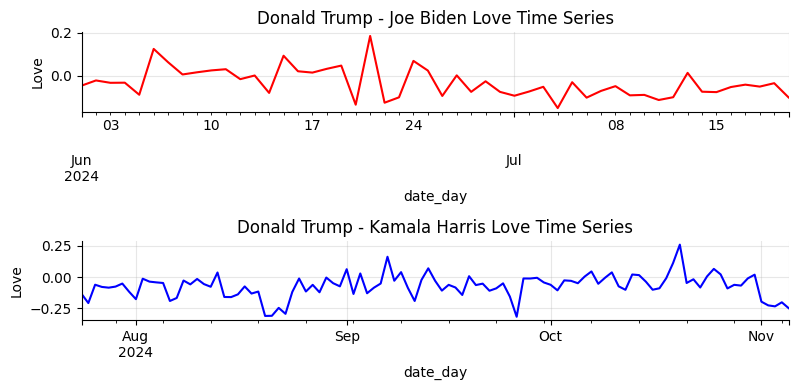

In both cases, higher than 0 means that Trump is more loved than the other candidate.


In [65]:
fig, ax = plt.subplots(2, 1, figsize=(8, 4))
trump_biden_diff.plot(ax=ax[0], color='red')
ax[0].set_title('Donald Trump - Joe Biden Love Time Series')
ax[0].set_ylabel('Love')
trump_harris_diff.plot(ax=ax[1], color='blue')
ax[1].set_title('Donald Trump - Kamala Harris Love Time Series')
ax[1].set_ylabel('Love')
plt.tight_layout()
plt.show()

print('In both cases, higher than 0 means that Trump is more loved than the other candidate.')

### Dickie-Fuller test

In [66]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # Perform Dickie-Fuller test:
    print('Results of Dickie-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
print('Trump - Biden Love Time Series:')
test_stationarity(trump_biden_diff)
print()
print('Trump - Harris Love Time Series:')
test_stationarity(trump_harris_diff)

Trump - Biden Love Time Series:
Results of Dickie-Fuller Test:
Test Statistic                 -1.451469
p-value                         0.557368
#Lags Used                      6.000000
Number of Observations Used    43.000000
Critical Value (1%)            -3.592504
Critical Value (5%)            -2.931550
Critical Value (10%)           -2.604066
dtype: float64

Trump - Harris Love Time Series:
Results of Dickie-Fuller Test:
Test Statistic                -6.155197e+00
p-value                        7.397471e-08
#Lags Used                     0.000000e+00
Number of Observations Used    1.040000e+02
Critical Value (1%)           -3.494850e+00
Critical Value (5%)           -2.889758e+00
Critical Value (10%)          -2.581822e+00
dtype: float64


**Trump - Biden Love Time Series:**

Test Statistic: -1.451469
p-value: 0.557368
Since the p-value is greater than 0.05, we fail to reject the null hypothesis and conclude that this time series is **non-stationary** (i.e., it has a unit root).
Critical Values: The test statistic is higher than all the critical values (at 1%, 5%, and 10%), confirming the failure to reject the null hypothesis of a unit root.

**Trump - Harris Love Time Series:**

Test Statistic: -6.155197
p-value: 7.397471e-08
Since the p-value is much smaller than 0.05, we reject the null hypothesis and conclude that this time series is **stationary** (i.e., it does not have a unit root).
Critical Values: The test statistic is significantly lower than the critical values at all levels, confirming the rejection of the null hypothesis.

In [68]:
train_size_biden = int(len(trump_biden_diff) * 0.9)
train_size_harris = int(len(trump_harris_diff) * 0.9)
trump_biden_diff_train = trump_biden_diff.iloc[:train_size_biden]
trump_biden_diff_test = trump_biden_diff.iloc[train_size_biden:]
trump_harris_diff_train = trump_harris_diff.iloc[:train_size_harris]
trump_harris_diff_test = trump_harris_diff.iloc[train_size_harris:]



### Integration for Trump - Biden

In [69]:
diff_1_trump_biden = trump_biden_diff.diff().dropna()

test_stationarity(diff_1_trump_biden)

Results of Dickie-Fuller Test:
Test Statistic                 -3.793402
p-value                         0.002976
#Lags Used                      5.000000
Number of Observations Used    43.000000
Critical Value (1%)            -3.592504
Critical Value (5%)            -2.931550
Critical Value (10%)           -2.604066
dtype: float64


Doing an integration of the series, we can see that the series is stationary, son a value of d=1 is enough to make it stationary.

### ACF

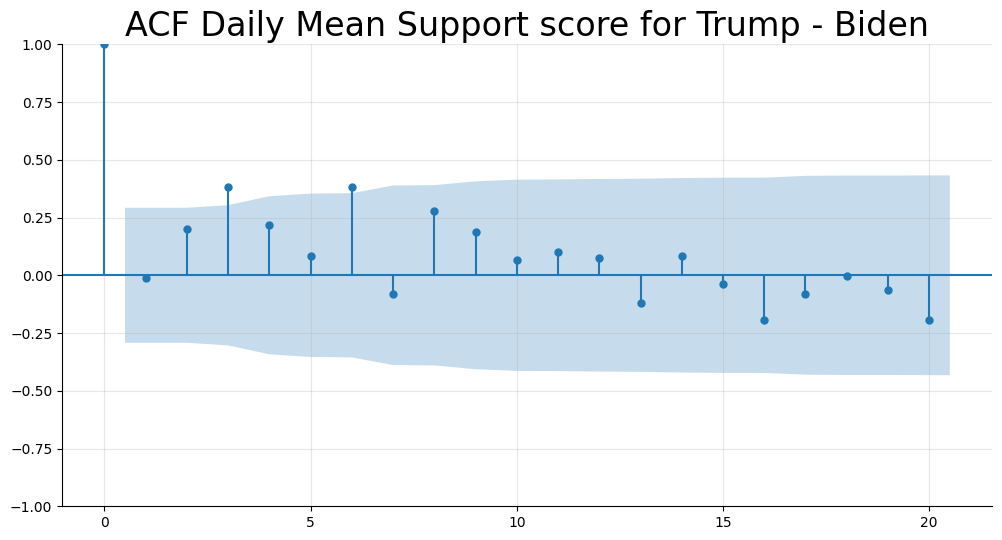

In [71]:
sgt.plot_acf(trump_biden_diff_train, lags = 20, zero = True)
plt.title("ACF Daily Mean Support score for Trump - Biden", size = 24)
plt.show()


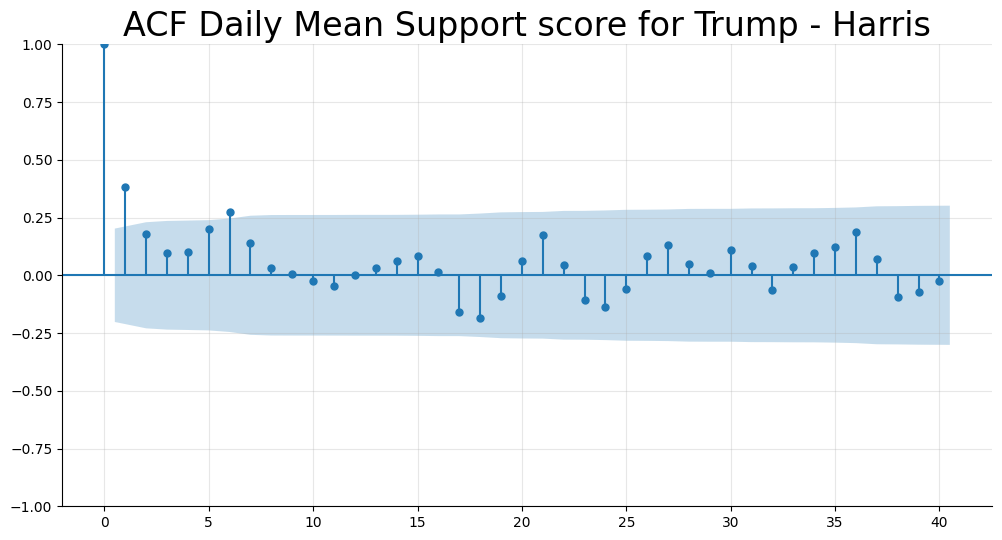

In [72]:
sgt.plot_acf(trump_harris_diff_train, lags = 40, zero = True)
plt.title("ACF Daily Mean Support score for Trump - Harris", size = 24)
plt.show()

### PACF

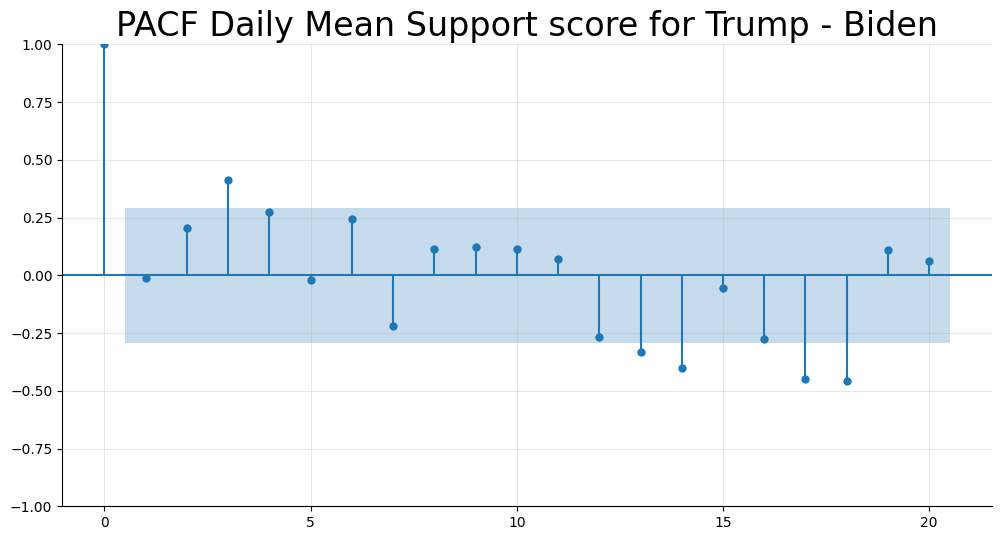

In [73]:
sgt.plot_pacf(trump_biden_diff_train, lags = 20, zero = True, method = ('ols'))
plt.title("PACF Daily Mean Support score for Trump - Biden", size = 24)
plt.show()

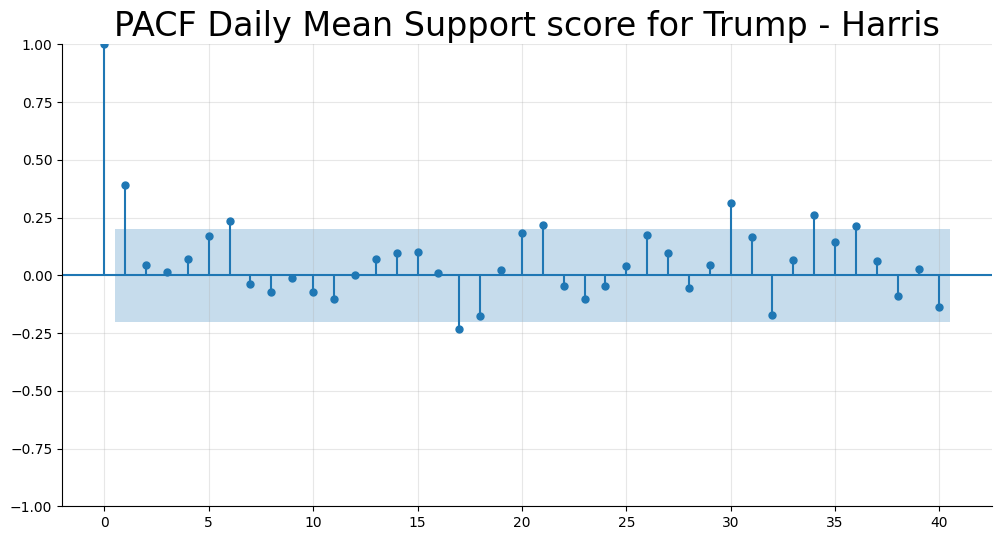

In [74]:
sgt.plot_pacf(trump_harris_diff_train, lags = 40, zero = True, method = ('ols'))
plt.title("PACF Daily Mean Support score for Trump - Harris", size = 24)
plt.show()


Conclusion

Trump - Biden Love Time Series:
- The ACF plot shows a huge peak on 0, then a sharp decrease, with all following values being within the confidence interval, some of them going outside, but no pattern so seasonality is rejected. The series seems to be random.
- The PACF plot shows the same pattern as the ACF plot, more peaks outside the confidence interval, but no pattern, so seasonality is rejected.

Trump - Harris Love Time Series:
- The ACF plot shows a huge peak on 0, then an smaller value on 1, then a sharp decrease, with almost all following values being within the confidence interval, some of them going outside, but no pattern so seasonality is rejected. 
- The PACF plot shows the same pattern as the ACF plot, more peaks outside the confidence interval, but no pattern, so seasonality is rejected.

### AR(I)MA

Trump-Biden arima

In [76]:
trump_biden_arima = pm.auto_arima(trump_biden_diff_train, seasonal = False, stationary=False, stepwise = False, suppress_warnings = True, error_action = "ignore", trace = True,
                            max_p=10,
                            max_q=10,
                            max_d=5,
                            n_fits=1000,
                            max_order=None)
trump_biden_arima.summary()
                                  

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-71.770, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-107.668, Time=0.02 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-105.672, Time=0.04 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-106.234, Time=0.05 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-104.736, Time=0.06 sec
 ARIMA(0,1,6)(0,0,0)[0] intercept   : AIC=-106.092, Time=0.08 sec
 ARIMA(0,1,7)(0,0,0)[0] intercept   : AIC=-102.036, Time=0.11 sec
 ARIMA(0,1,8)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,9)(0,0,0)[0] intercept   : AIC=-103.266, Time=0.20 sec
 ARIMA(0,1,10)(0,0,0)[0] intercept   : AIC=-100.888, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-89.473, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-106.481, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-105.354, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-103.903, Time=0.05 sec
 ARIMA(1,1,4)(0,0,0)[

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   45
Model:               SARIMAX(0, 1, 2)   Log Likelihood                  57.834
Date:                Wed, 20 Nov 2024   AIC                           -107.668
Time:                        10:25:45   BIC                           -100.532
Sample:                    06-01-2024   HQIC                          -105.022
                         - 07-15-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0011      0.002     -0.568      0.570      -0.005       0.003
ma.L1         -1.1804      0.135     -8.716      0.000      -1.446      -0.915
ma.L2          0.3709      0.116      3.190      0.001       0.143       0.599
sigma2         0.0041      0.001      4.827      0.000       0.002       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.30
Prob(Q):                              0.89   Prob(JB):                         0.86
Heteroskedasticity (H):               0.43   Skew:                             0.09
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Trump-Harris arima

In [77]:
trump_harris_arima = pm.auto_arima(trump_harris_diff_train, seasonal = False, stationary=True, stepwise = False, suppress_warnings = True, error_action = "ignore", trace = True,
                            max_p=10,
                            max_q=10,
                            max_d=5,
                            n_fits=1000,
                            max_order=None)

trump_harris_arima.summary()


 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-177.910, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-188.296, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-188.597, Time=0.01 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-187.096, Time=0.02 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=-185.152, Time=0.03 sec
 ARIMA(0,0,5)(0,0,0)[0] intercept   : AIC=-183.161, Time=0.05 sec
 ARIMA(0,0,6)(0,0,0)[0] intercept   : AIC=-187.302, Time=0.08 sec
 ARIMA(0,0,7)(0,0,0)[0] intercept   : AIC=-187.094, Time=0.09 sec
 ARIMA(0,0,8)(0,0,0)[0] intercept   : AIC=-185.110, Time=0.11 sec
 ARIMA(0,0,9)(0,0,0)[0] intercept   : AIC=-183.116, Time=0.28 sec
 ARIMA(0,0,10)(0,0,0)[0] intercept   : AIC=-181.564, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-190.973, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-189.194, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-188.644, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-186.812, Time=0.12 sec
 ARIMA(1,

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   94
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  98.486
Date:                Wed, 20 Nov 2024   AIC                           -190.973
Time:                        10:26:22   BIC                           -183.343
Sample:                    07-24-2024   HQIC                          -187.891
                         - 10-25-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0402      0.011     -3.749      0.000      -0.061      -0.019
ar.L1          0.3879      0.080      4.880      0.000       0.232       0.544
sigma2         0.0072      0.001      7.152      0.000       0.005       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.59
Prob(Q):                              0.89   Prob(JB):                         0.45
Heteroskedasticity (H):               1.17   Skew:                             0.10
Prob(H) (two-sided):                  0.67   Kurtosis:                         3.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

forecasting

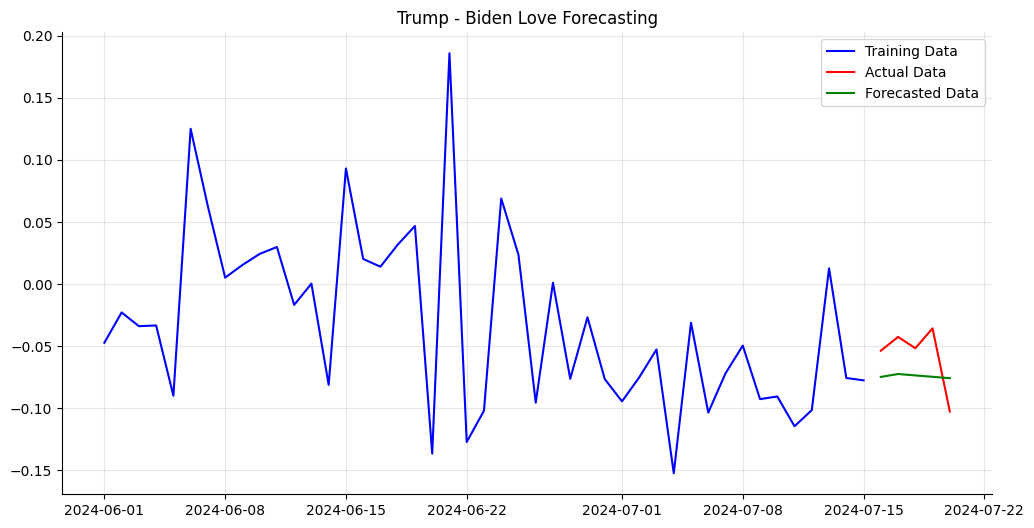

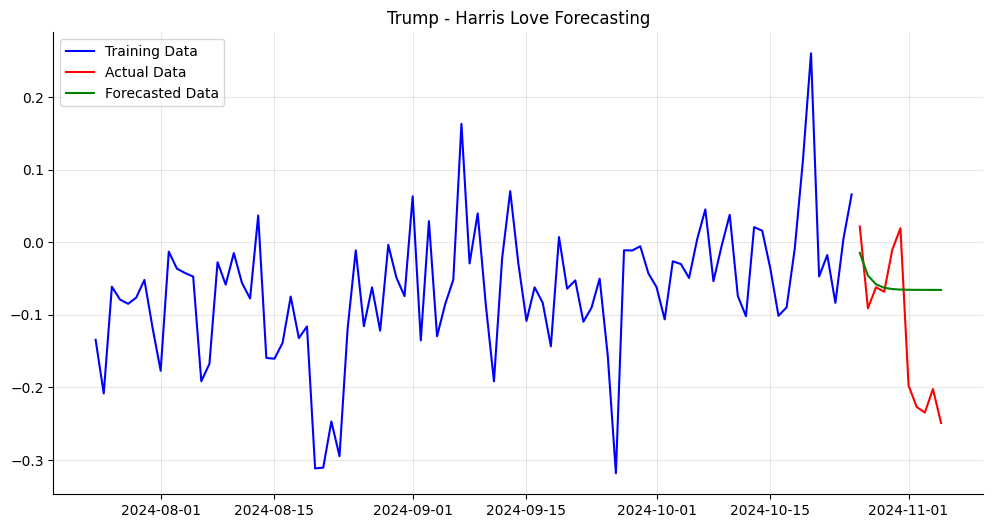

In [79]:

results_arma_trump_biden_forecast = trump_biden_arima.predict(n_periods=len(trump_biden_diff_test))
results_arma_trump_harris_forecast = trump_harris_arima.predict(n_periods=len(trump_harris_diff_test))

# Plot the forecasted values vs the actual test values
plt.figure(figsize=(12, 6))
plt.plot(trump_biden_diff_train, label='Training Data', color='blue')
plt.plot(trump_biden_diff_test, label='Actual Data', color='red')
plt.plot(results_arma_trump_biden_forecast, label='Forecasted Data', color='green')
plt.title('Trump - Biden Love Forecasting')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(trump_harris_diff_train, label='Training Data', color='blue')
plt.plot(trump_harris_diff_test, label='Actual Data', color='red')
plt.plot(results_arma_trump_harris_forecast, label='Forecasted Data', color='green')
plt.title('Trump - Harris Love Forecasting')
plt.legend()

plt.show()


### Conclusion
Finally, the predictions were good, given the small dataset and the apparent randomness of the data. In conclusion, predicting sentiment scores is a difficult task, but with the right tools and methods, it can be done with acceptable accuracy.

# Correlation with polls/google interest

In [3]:
df_trump_biden = pd.read_csv('../data/processed/final_dataset_trump_biden.csv')
df_trump_harris = pd.read_csv('../data/processed/final_dataset_trump_harris.csv')
df_trump_harris.head()

,date_day,polls_Trump,polls_Harris,google_Harris,google_Trump,donald_trump_love,donald_trump_hate,kamala_harris_love,kamala_harris_hate
0,2024-07-24,0.440377,0.448710,0.105,0.075,0.352375,0.647625,0.486752,0.513248
1,2024-07-25,0.442427,0.446329,0.115,0.065,0.350676,0.649324,0.558862,0.441138
2,2024-07-26,0.440460,0.437328,0.085,0.060,0.367760,0.632240,0.428942,0.571058
3,2024-07-27,0.440216,0.437453,0.060,0.070,0.378309,0.621691,0.457191,0.542809
4,2024-07-28,0.441076,0.438446,0.050,0.070,0.293569,0.706431,0.378350,0.621650


In [4]:
donald_trump_love_when_biden = df_trump_biden['donald_trump_love']
donald_trump_love_when_harris = df_trump_harris['donald_trump_love']
joe_biden_love = df_trump_biden['joe_biden_love']
kamala_harris_love = df_trump_harris['kamala_harris_love']

polls_trump_when_biden = df_trump_biden['polls_Trump']
polls_trump_when_harris = df_trump_harris['polls_Trump']
polls_biden = df_trump_biden['polls_Biden']
polls_harris = df_trump_harris['polls_Harris']

google_trump_when_biden = df_trump_biden['google_Trump']
google_trump_when_harris = df_trump_harris['google_Trump']
google_biden = df_trump_biden['google_Biden']
google_harris = df_trump_harris['google_Harris']

# for all the time series, convert date_day to datetime and set it as index
donald_trump_love_when_biden.index = pd.to_datetime(df_trump_biden['date_day'])
donald_trump_love_when_harris.index = pd.to_datetime(df_trump_harris['date_day'])
joe_biden_love.index = pd.to_datetime(df_trump_biden['date_day'])
kamala_harris_love.index = pd.to_datetime(df_trump_harris['date_day'])
polls_trump_when_biden.index = pd.to_datetime(df_trump_biden['date_day'])
polls_trump_when_harris.index = pd.to_datetime(df_trump_harris['date_day'])
polls_biden.index = pd.to_datetime(df_trump_biden['date_day'])
polls_harris.index = pd.to_datetime(df_trump_harris['date_day'])
google_trump_when_biden.index = pd.to_datetime(df_trump_biden['date_day'])
google_trump_when_harris.index = pd.to_datetime(df_trump_harris['date_day'])
google_biden.index = pd.to_datetime(df_trump_biden['date_day'])
google_harris.index = pd.to_datetime(df_trump_harris['date_day'])



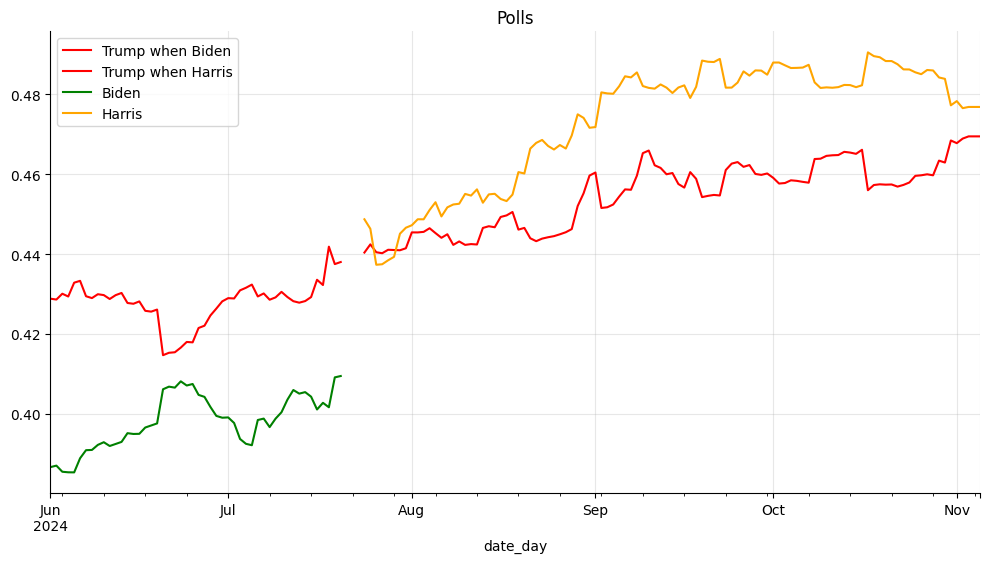

In [5]:
# plot all polls
plt.figure(figsize=(12, 6))
polls_trump_when_biden.plot(label='Trump when Biden', color='red')
polls_trump_when_harris.plot(label='Trump when Harris', color='red')
polls_biden.plot(label='Biden', color='green')
polls_harris.plot(label='Harris', color='orange')
plt.title('Polls')
plt.legend()
plt.show()

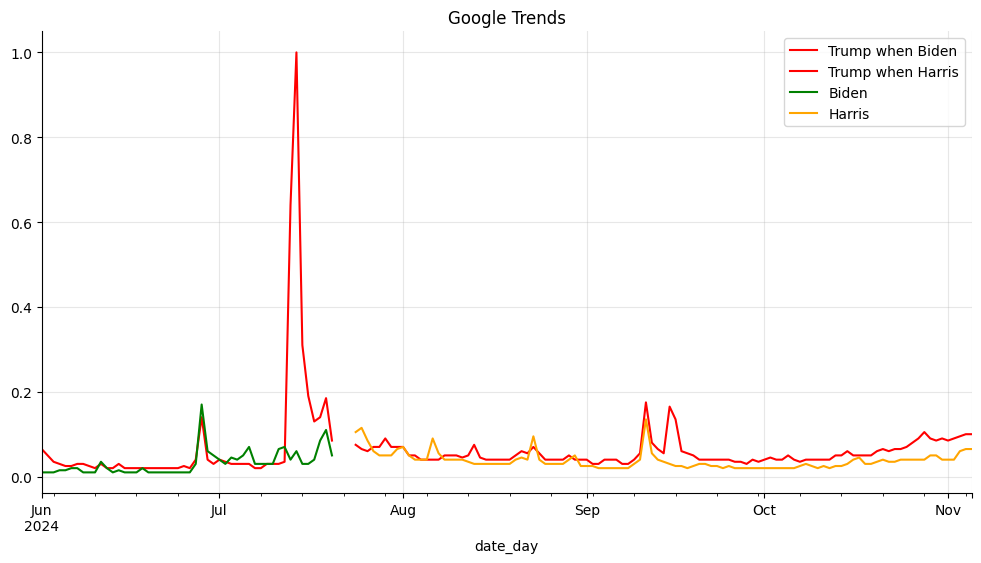

In [6]:
# plot all google trends
plt.figure(figsize=(12, 6))
google_trump_when_biden.plot(label='Trump when Biden', color='red')
google_trump_when_harris.plot(label='Trump when Harris', color='red')
google_biden.plot(label='Biden', color='green')
google_harris.plot(label='Harris', color='orange')
plt.title('Google Trends')
plt.legend()
plt.show()


## Sentiment as exogenous variable for polls 

### Obtaining best params

In [30]:
print('Trump when Biden, taking into account Trump love')
arima_trump_when_biden_trump_love = pm.auto_arima(polls_trump_when_biden, seasonal = False, stationary=True, stepwise = True, suppress_warnings = True, error_action = "ignore", trace = True,
                            start_p=0, start_q=0, max_p=10, max_q=10, n_fits=1000, max_order=None,
                            exogenous=donald_trump_love_when_biden)

print('Trump when Harris, taking into account Trump love')
arima_trump_when_harris_trump_love = pm.auto_arima(polls_trump_when_harris, seasonal = False, stationary=True, stepwise = True, suppress_warnings = True, error_action = "ignore", trace = True,
                            start_p=0, start_q=0, max_p=10, max_q=10, n_fits=1000, max_order=None,
                            exogenous=donald_trump_love_when_harris)

print('Trump when Biden, taking into account Biden love')
arima_trump_when_biden_biden_love = pm.auto_arima(polls_trump_when_biden, seasonal = False, stationary=True, stepwise = True, suppress_warnings = True, error_action = "ignore", trace = True,
                                                  start_p=0, start_q=0, max_p=10, max_q=10, n_fits=1000, max_order=None,
                                                  exogenous=joe_biden_love)

print('Trump when Harris, taking into account Harris love')
arima_trump_when_harris_harris_love = pm.auto_arima(polls_trump_when_harris, seasonal = False, stationary=True, stepwise = True, suppress_warnings = True, error_action = "ignore", trace = True,
                            start_p=0, start_q=0, max_p=10, max_q=10, n_fits=1000, max_order=None,
                            exogenous=kamala_harris_love)

print('Trump when Biden, taking into account Trump and Biden love')
arima_trump_when_biden_trump_biden_love = pm.auto_arima(polls_trump_when_biden, seasonal = False, stationary=True, stepwise = True, suppress_warnings = True, error_action = "ignore", trace = True,
                            start_p=0, start_q=0, max_p=10, max_q=10, n_fits=1000, max_order=None,
                            exogenous=pd.concat([donald_trump_love_when_biden, joe_biden_love], axis=1))

print('Trump when Harris, taking into account Trump and Harris love')
arima_trump_when_harris_trump_harris_love = pm.auto_arima(polls_trump_when_harris, seasonal = False, stationary=True, stepwise = True, suppress_warnings = True, error_action = "ignore", trace = True,
                            start_p=0, start_q=0, max_p=10, max_q=10, n_fits=1000, max_order=None,
                            exogenous=pd.concat([donald_trump_love_when_harris, kamala_harris_love], axis=1))

print('Biden taking into account Trump love')
arima_biden_trump_love = pm.auto_arima(polls_biden, seasonal = False, stationary=True, stepwise = True, suppress_warnings = True, error_action = "ignore", trace = True,
                            start_p=0, start_q=0, max_p=10, max_q=10, n_fits=1000, max_order=None,
                            exogenous=donald_trump_love_when_biden)

print('Biden taking into account Biden love')
arima_biden_biden_love = pm.auto_arima(polls_biden, seasonal = False, stationary=True, stepwise = True, suppress_warnings = True, error_action = "ignore", trace = True,
                            start_p=0, start_q=0, max_p=10, max_q=10, n_fits=1000, max_order=None,
                            exogenous=joe_biden_love)

print('Biden taking into account Trump and Biden love')
arima_biden_trump_biden_love = pm.auto_arima(polls_biden, seasonal = False, stationary=True, stepwise = True, suppress_warnings = True, error_action = "ignore", trace = True,
                            start_p=0, start_q=0, max_p=10, max_q=10, n_fits=1000, max_order=None,
                            exogenous=pd.concat([donald_trump_love_when_biden, joe_biden_love], axis=1))

print('Harris taking into account Trump love')
arima_harris_trump_love = pm.auto_arima(polls_harris, seasonal = False, stationary=True, stepwise = True, suppress_warnings = True, error_action = "ignore", trace = True,
                            start_p=0, start_q=0, max_p=10, max_q=10, n_fits=1000, max_order=None,
                            exogenous=donald_trump_love_when_harris)

print('Harris taking into account Harris love')
arima_harris_harris_love = pm.auto_arima(polls_harris, seasonal = False, stationary=True, stepwise = True, suppress_warnings = True, error_action = "ignore", trace = True,
                            start_p=0, start_q=0, max_p=10, max_q=10, n_fits=1000, max_order=None,
                            exogenous=kamala_harris_love)

print('Harris taking into account Trump and Harris love')
arima_harris_trump_harris_love = pm.auto_arima(polls_harris, seasonal = False, stationary=True, stepwise = True, suppress_warnings = True, error_action = "ignore", trace = True,
                            start_p=0, start_q=0, max_p=10, max_q=10, n_fits=1000, max_order=None,
                            exogenous=pd.concat([donald_trump_love_when_harris, kamala_harris_love], axis=1))





Trump when Biden, taking into account Trump love
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-374.711, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-444.098, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-405.755, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=59.030, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-442.859, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-442.693, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-440.407, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.140 seconds
Trump when Harris, taking into account Trump love
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-699.327, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-961.092, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-805.796, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0

### Obtaining coefficients

In [31]:


warnings.filterwarnings("ignore")

    

In [32]:
arima_trump_when_biden_trump_love = ARIMA(polls_trump_when_biden, exog=donald_trump_love_when_biden, order=(1,0,0)).fit()
arima_trump_when_biden_trump_love.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            polls_Trump   No. Observations:                   50
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 227.382
Date:                Thu, 21 Nov 2024   AIC                           -446.763
Time:                        16:10:16   BIC                           -439.115
Sample:                    06-01-2024   HQIC                          -443.851
                         - 07-20-2024                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.4233      0.004    106.125      0.000       0.415       0.431
donald_trump_love     0.0179      0.010      1.782      0.075      -0.002       0.038
ar.L1                 0.9071      0.076     11.870      0.000       0.757       1.057
sigma2              6.32e-06   1.04e-06      6.086      0.000    4.28e-06    8.36e-06
===================================================================================
Ljung-Box (L1) (Q):                   1.02   Jarque-Bera (JB):                75.67
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               3.79   Skew:                             0.02
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
arima_trump_when_harris_trump_love = ARIMA(polls_trump_when_harris, exog=donald_trump_love_when_harris, order=(1,0,0)).fit()
arima_trump_when_harris_trump_love.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            polls_Trump   No. Observations:                  105
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 482.374
Date:                Thu, 21 Nov 2024   AIC                           -956.748
Time:                        16:10:16   BIC                           -946.133
Sample:                    07-24-2024   HQIC                          -952.447
                         - 11-05-2024                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.4542      0.003    161.117      0.000       0.449       0.460
donald_trump_love     0.0017      0.004      0.468      0.640      -0.005       0.009
ar.L1                 0.9310      0.027     34.272      0.000       0.878       0.984
sigma2             5.851e-06   5.73e-07     10.206      0.000    4.73e-06    6.98e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.78   Jarque-Bera (JB):                53.90
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               1.59   Skew:                            -0.53
Prob(H) (two-sided):                  0.17   Kurtosis:                         6.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
arima_trump_when_biden_biden_love = ARIMA(polls_trump_when_biden, exog=joe_biden_love, order=(1,0,0)).fit()
arima_trump_when_biden_biden_love.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            polls_Trump   No. Observations:                   50
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 225.121
Date:                Thu, 21 Nov 2024   AIC                           -442.241
Time:                        16:10:16   BIC                           -434.593
Sample:                    06-01-2024   HQIC                          -439.329
                         - 07-20-2024                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.4296      0.008     56.030      0.000       0.415       0.445
joe_biden_love    -0.0008      0.010     -0.084      0.933      -0.020       0.018
ar.L1              0.8894      0.101      8.764      0.000       0.690       1.088
sigma2          6.943e-06   7.39e-07      9.399      0.000     5.5e-06    8.39e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):               180.18
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               3.43   Skew:                            -0.65
Prob(H) (two-sided):                  0.02   Kurtosis:                        12.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
arima_trump_when_harris_harris_love = ARIMA(polls_trump_when_harris, exog=kamala_harris_love, order=(1,0,0)).fit()
arima_trump_when_harris_harris_love.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            polls_Trump   No. Observations:                  105
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 483.558
Date:                Thu, 21 Nov 2024   AIC                           -959.116
Time:                        16:10:16   BIC                           -948.500
Sample:                    07-24-2024   HQIC                          -954.815
                         - 11-05-2024                                         
Covariance Type:                  opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4551      0.005     96.516      0.000       0.446       0.464
kamala_harris_love    -0.0006      0.004     -0.143      0.886      -0.008       0.007
ar.L1                  0.9604      0.030     31.822      0.000       0.901       1.020
sigma2              5.691e-06   5.08e-07     11.197      0.000    4.69e-06    6.69e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                83.27
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               1.91   Skew:                            -0.64
Prob(H) (two-sided):                  0.06   Kurtosis:                         7.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
arima_trump_when_biden_trump_biden_love = ARIMA(polls_trump_when_biden, exog=pd.concat([donald_trump_love_when_biden, joe_biden_love], axis=1), order=(1,0,0)).fit()
arima_trump_when_biden_trump_biden_love.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            polls_Trump   No. Observations:                   50
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 227.193
Date:                Thu, 21 Nov 2024   AIC                           -444.387
Time:                        16:10:16   BIC                           -434.827
Sample:                    06-01-2024   HQIC                          -440.746
                         - 07-20-2024                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.4234      0.006     73.430      0.000       0.412       0.435
donald_trump_love     0.0174      0.010      1.694      0.090      -0.003       0.038
joe_biden_love       -0.0009      0.007     -0.127      0.899      -0.015       0.013
ar.L1                 0.8679      0.079     11.031      0.000       0.714       1.022
sigma2             6.434e-06   1.12e-06      5.722      0.000    4.23e-06    8.64e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                82.74
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               3.98   Skew:                             0.06
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
arima_trump_when_harris_trump_harris_love = ARIMA(polls_trump_when_harris, exog=pd.concat([donald_trump_love_when_harris, kamala_harris_love], axis=1), order=(1,0,0)).fit()
arima_trump_when_harris_trump_harris_love.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            polls_Trump   No. Observations:                  105
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 482.594
Date:                Thu, 21 Nov 2024   AIC                           -955.188
Time:                        16:10:16   BIC                           -941.919
Sample:                    07-24-2024   HQIC                          -949.811
                         - 11-05-2024                                         
Covariance Type:                  opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4544      0.004    124.742      0.000       0.447       0.462
donald_trump_love      0.0017      0.004      0.456      0.648      -0.005       0.009
kamala_harris_love    -0.0005      0.004     -0.136      0.892      -0.008       0.007
ar.L1                  0.9344      0.028     33.007      0.000       0.879       0.990
sigma2               5.83e-06    5.7e-07     10.223      0.000    4.71e-06    6.95e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):                56.53
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               1.64   Skew:                            -0.54
Prob(H) (two-sided):                  0.15   Kurtosis:                         6.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
arima_biden_trump_love = ARIMA(polls_biden, exog=donald_trump_love_when_biden, order=(1,0,0)).fit()
arima_biden_trump_love.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            polls_Biden   No. Observations:                   50
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 229.547
Date:                Thu, 21 Nov 2024   AIC                           -451.093
Time:                        16:10:17   BIC                           -443.445
Sample:                    06-01-2024   HQIC                          -448.181
                         - 07-20-2024                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3997      0.006     62.902      0.000       0.387       0.412
donald_trump_love    -0.0047      0.006     -0.771      0.441      -0.017       0.007
ar.L1                 0.9600      0.064     14.923      0.000       0.834       1.086
sigma2             5.701e-06   8.89e-07      6.415      0.000    3.96e-06    7.44e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):                23.56
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               3.48   Skew:                             1.22
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
arima_biden_biden_love = ARIMA(polls_biden, exog=joe_biden_love, order=(1,0,0)).fit()
arima_biden_biden_love.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            polls_Biden   No. Observations:                   50
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 229.537
Date:                Thu, 21 Nov 2024   AIC                           -451.075
Time:                        16:10:17   BIC                           -443.427
Sample:                    06-01-2024   HQIC                          -448.163
                         - 07-20-2024                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3972      0.007     59.493      0.000       0.384       0.410
joe_biden_love     0.0024      0.007      0.353      0.724      -0.011       0.016
ar.L1              0.9595      0.066     14.486      0.000       0.830       1.089
sigma2          5.704e-06    8.5e-07      6.707      0.000    4.04e-06    7.37e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.76   Jarque-Bera (JB):                29.80
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               3.83   Skew:                             1.31
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
arima_biden_biden_trump_love = ARIMA(polls_biden, exog=pd.concat([donald_trump_love_when_biden, joe_biden_love], axis=1), order=(1,0,0)).fit()
arima_biden_biden_trump_love.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            polls_Biden   No. Observations:                   50
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 228.739
Date:                Thu, 21 Nov 2024   AIC                           -447.479
Time:                        16:10:17   BIC                           -437.918
Sample:                    06-01-2024   HQIC                          -443.838
                         - 07-20-2024                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3988      0.005     86.125      0.000       0.390       0.408
donald_trump_love    -0.0049      0.007     -0.657      0.511      -0.019       0.010
joe_biden_love        0.0026      0.007      0.382      0.702      -0.011       0.016
ar.L1                 0.8961      0.063     14.122      0.000       0.772       1.020
sigma2             5.999e-06   9.98e-07      6.012      0.000    4.04e-06    7.95e-06
===================================================================================
Ljung-Box (L1) (Q):                   1.64   Jarque-Bera (JB):                16.74
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               2.51   Skew:                             0.97
Prob(H) (two-sided):                  0.07   Kurtosis:                         5.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
arima_harris_trump_love = ARIMA(polls_harris, exog=donald_trump_love_when_harris, order=(1,0,0)).fit()
arima_harris_trump_love.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           polls_Harris   No. Observations:                  105
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 463.678
Date:                Thu, 21 Nov 2024   AIC                           -919.356
Time:                        16:10:18   BIC                           -908.740
Sample:                    07-24-2024   HQIC                          -915.054
                         - 11-05-2024                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.4735      0.003    161.317      0.000       0.468       0.479
donald_trump_love    -0.0052      0.005     -1.077      0.282      -0.015       0.004
ar.L1                 0.9062      0.021     43.413      0.000       0.865       0.947
sigma2             8.398e-06   9.32e-07      9.009      0.000    6.57e-06    1.02e-05
===================================================================================
Ljung-Box (L1) (Q):                   7.71   Jarque-Bera (JB):                65.83
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                            -0.60
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
arima_harris_harris_love = ARIMA(polls_harris, exog=kamala_harris_love, order=(1,0,0)).fit()
arima_harris_harris_love.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           polls_Harris   No. Observations:                  105
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 473.132
Date:                Thu, 21 Nov 2024   AIC                           -938.263
Time:                        16:10:18   BIC                           -927.648
Sample:                    07-24-2024   HQIC                          -933.962
                         - 11-05-2024                                         
Covariance Type:                  opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4695      0.004    106.823      0.000       0.461       0.478
kamala_harris_love     0.0011      0.003      0.324      0.746      -0.006       0.008
ar.L1                  0.9573      0.017     56.501      0.000       0.924       0.990
sigma2              6.946e-06   6.34e-07     10.961      0.000     5.7e-06    8.19e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.73   Jarque-Bera (JB):                58.60
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                            -0.11
Prob(H) (two-sided):                  0.05   Kurtosis:                         6.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
arima_harris_harris_trump_love = ARIMA(polls_harris, exog=pd.concat([donald_trump_love_when_harris, kamala_harris_love], axis=1), order=(1,0,0)).fit()
arima_harris_harris_trump_love.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           polls_Harris   No. Observations:                  105
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 476.231
Date:                Thu, 21 Nov 2024   AIC                           -942.462
Time:                        16:10:19   BIC                           -929.192
Sample:                    07-24-2024   HQIC                          -937.085
                         - 11-05-2024                                         
Covariance Type:                  opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4685      0.011     41.253      0.000       0.446       0.491
donald_trump_love     -0.0059      0.004     -1.508      0.132      -0.013       0.002
kamala_harris_love     0.0013      0.003      0.367      0.714      -0.005       0.008
ar.L1                  0.9869      0.016     61.134      0.000       0.955       1.019
sigma2              6.475e-06   5.89e-07     10.994      0.000    5.32e-06    7.63e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):                46.74
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                             0.13
Prob(H) (two-sided):                  0.06   Kurtosis:                         6.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Sentiment as exogenous variable for google searches

### Obtaining best params

In [44]:
print('Trump when Biden, taking into account Trump love')
arima_trump_when_biden_trump_love = pm.auto_arima(google_trump_when_biden, seasonal = False, stationary=True, stepwise = True, suppress_warnings = True, error_action = "ignore", trace = True,
                            start_p=0, start_q=0, max_p=10, max_q=10, n_fits=1000, max_order=None,
                            exogenous=donald_trump_love_when_biden)

print('Trump when Harris, taking into account Trump love')
arima_trump_when_harris_trump_love = pm.auto_arima(google_trump_when_harris, seasonal = False, stationary=True, stepwise = True, suppress_warnings = True, error_action = "ignore", trace = True,
                            start_p=0, start_q=0, max_p=10, max_q=10, n_fits=1000, max_order=None,
                            exogenous=donald_trump_love_when_harris)

print('Trump when Biden, taking into account Biden love')
arima_trump_when_biden_biden_love = pm.auto_arima(google_trump_when_biden, seasonal = False, stationary=True, stepwise = True, suppress_warnings = True, error_action = "ignore", trace = True,
                                                  start_p=0, start_q=0, max_p=10, max_q=10, n_fits=1000, max_order=None,
                                                  exogenous=joe_biden_love)

print('Trump when Harris, taking into account Harris love')
arima_trump_when_harris_harris_love = pm.auto_arima(google_trump_when_harris, seasonal = False, stationary=True, stepwise = True, suppress_warnings = True, error_action = "ignore", trace = True,
                            start_p=0, start_q=0, max_p=10, max_q=10, n_fits=1000, max_order=None,
                            exogenous=kamala_harris_love)

print('Trump when Biden, taking into account Trump and Biden love')
arima_trump_when_biden_trump_biden_love = pm.auto_arima(google_trump_when_biden, seasonal = False, stationary=True, stepwise = True, suppress_warnings = True, error_action = "ignore", trace = True,
                            start_p=0, start_q=0, max_p=10, max_q=10, n_fits=1000, max_order=None,
                            exogenous=pd.concat([donald_trump_love_when_biden, joe_biden_love], axis=1))

print('Trump when Harris, taking into account Trump and Harris love')
arima_trump_when_harris_trump_harris_love = pm.auto_arima(google_trump_when_harris, seasonal = False, stationary=True, stepwise = True, suppress_warnings = True, error_action = "ignore", trace = True,
                            start_p=0, start_q=0, max_p=10, max_q=10, n_fits=1000, max_order=None,
                            exogenous=pd.concat([donald_trump_love_when_harris, kamala_harris_love], axis=1))

print('Biden taking into account Trump love')
arima_biden_trump_love = pm.auto_arima(google_biden, seasonal = False, stationary=True, stepwise = True, suppress_warnings = True, error_action = "ignore", trace = True,
                            start_p=0, start_q=0, max_p=10, max_q=10, n_fits=1000, max_order=None,
                            exogenous=donald_trump_love_when_biden)

print('Biden taking into account Biden love')
arima_biden_biden_love = pm.auto_arima(google_biden, seasonal = False, stationary=True, stepwise = True, suppress_warnings = True, error_action = "ignore", trace = True,
                            start_p=0, start_q=0, max_p=10, max_q=10, n_fits=1000, max_order=None,
                            exogenous=joe_biden_love)

print('Biden taking into account Trump and Biden love')
arima_biden_trump_biden_love = pm.auto_arima(google_biden, seasonal = False, stationary=True, stepwise = True, suppress_warnings = True, error_action = "ignore", trace = True,
                            start_p=0, start_q=0, max_p=10, max_q=10, n_fits=1000, max_order=None,
                            exogenous=pd.concat([donald_trump_love_when_biden, joe_biden_love], axis=1))

print('Harris taking into account Trump love')
arima_harris_trump_love = pm.auto_arima(google_harris, seasonal = False, stationary=True, stepwise = True, suppress_warnings = True, error_action = "ignore", trace = True,
                            start_p=0, start_q=0, max_p=10, max_q=10, n_fits=1000, max_order=None,
                            exogenous=donald_trump_love_when_harris)

print('Harris taking into account Harris love')
arima_harris_harris_love = pm.auto_arima(google_harris, seasonal = False, stationary=True, stepwise = True, suppress_warnings = True, error_action = "ignore", trace = True,
                            start_p=0, start_q=0, max_p=10, max_q=10, n_fits=1000, max_order=None,
                            exogenous=kamala_harris_love)

print('Harris taking into account Trump and Harris love')
arima_harris_trump_harris_love = pm.auto_arima(google_harris, seasonal = False, stationary=True, stepwise = True, suppress_warnings = True, error_action = "ignore", trace = True,
                            start_p=0, start_q=0, max_p=10, max_q=10, n_fits=1000, max_order=None,
                            exogenous=pd.concat([donald_trump_love_when_harris, kamala_harris_love], axis=1))




Trump when Biden, taking into account Trump love
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-34.336, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-56.475, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-64.200, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-25.912, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-63.576, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-63.231, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-62.025, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-59.773, Time=0.01 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.091 seconds
Trump when Harris, taking into account Trump love
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-471.179, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-520.428, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-504.803, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)

### Obtaining coefficients

In [45]:
arima_trump_when_biden_trump_love = ARIMA(google_trump_when_biden, exog=donald_trump_love_when_biden, order=(0,0,1)).fit()
arima_trump_when_biden_trump_love.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           google_Trump   No. Observations:                   50
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  37.425
Date:                Thu, 21 Nov 2024   AIC                            -66.850
Time:                        16:14:40   BIC                            -59.202
Sample:                    06-01-2024   HQIC                           -63.938
                         - 07-20-2024                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3361      0.119      2.829      0.005       0.103       0.569
donald_trump_love    -0.7114      0.329     -2.162      0.031      -1.356      -0.066
ma.L1                 0.9996      7.484      0.134      0.894     -13.669      15.668
sigma2                0.0121      0.090      0.135      0.893      -0.164       0.189
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):               480.57
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):              30.25   Skew:                             3.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
arima_trump_when_biden_biden_love = ARIMA(google_trump_when_biden, exog=joe_biden_love, order=(0,0,1)).fit()
arima_trump_when_biden_biden_love.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           google_Trump   No. Observations:                   50
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  35.220
Date:                Thu, 21 Nov 2024   AIC                            -62.441
Time:                        16:16:52   BIC                            -54.793
Sample:                    06-01-2024   HQIC                           -59.528
                         - 07-20-2024                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0499      0.132      0.379      0.705      -0.208       0.308
joe_biden_love     0.0767      0.212      0.362      0.718      -0.339       0.493
ma.L1              0.8625      0.080     10.729      0.000       0.705       1.020
sigma2             0.0139      0.003      4.551      0.000       0.008       0.020
===================================================================================
Ljung-Box (L1) (Q):                   0.87   Jarque-Bera (JB):               417.20
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):              45.37   Skew:                             3.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
arima_trump_when_biden_trump_biden_love = ARIMA(google_trump_when_biden, exog=pd.concat([donald_trump_love_when_biden, joe_biden_love], axis=1), order=(0,0,1)).fit()
arima_trump_when_biden_trump_biden_love.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           google_Trump   No. Observations:                   50
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  37.492
Date:                Thu, 21 Nov 2024   AIC                            -64.984
Time:                        16:17:05   BIC                            -55.424
Sample:                    06-01-2024   HQIC                           -61.343
                         - 07-20-2024                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2991      0.330      0.906      0.365      -0.348       0.946
donald_trump_love    -0.6402      0.727     -0.880      0.379      -2.066       0.785
joe_biden_love        0.0291      0.193      0.151      0.880      -0.349       0.407
ma.L1                 0.9996      6.860      0.146      0.884     -12.447      14.446
sigma2                0.0121      0.082      0.147      0.883      -0.149       0.174
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):               526.83
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):              36.84   Skew:                             3.50
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
arima_trump_when_harris_trump_love = ARIMA(google_trump_when_harris, exog=donald_trump_love_when_harris, order=(1,0,0)).fit()
arima_trump_when_harris_trump_love.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           google_Trump   No. Observations:                  105
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 265.172
Date:                Thu, 21 Nov 2024   AIC                           -522.344
Time:                        16:15:54   BIC                           -511.728
Sample:                    07-24-2024   HQIC                          -518.043
                         - 11-05-2024                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0837      0.017      4.902      0.000       0.050       0.117
donald_trump_love    -0.0711      0.042     -1.705      0.088      -0.153       0.011
ar.L1                 0.6274      0.081      7.794      0.000       0.470       0.785
sigma2                0.0004   3.35e-05     11.140      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):              1624.99
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               1.33   Skew:                             3.31
Prob(H) (two-sided):                  0.40   Kurtosis:                        21.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [51]:
arima_trump_when_harris_harris_love = ARIMA(google_trump_when_harris, exog=kamala_harris_love, order=(1,0,0)).fit()
arima_trump_when_harris_harris_love.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           google_Trump   No. Observations:                  105
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 263.655
Date:                Thu, 21 Nov 2024   AIC                           -519.310
Time:                        16:17:45   BIC                           -508.694
Sample:                    07-24-2024   HQIC                          -515.008
                         - 11-05-2024                                         
Covariance Type:                  opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0455      0.024      1.909      0.056      -0.001       0.092
kamala_harris_love     0.0265      0.045      0.584      0.559      -0.062       0.115
ar.L1                  0.6244      0.076      8.209      0.000       0.475       0.773
sigma2                 0.0004   3.32e-05     11.570      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              1890.93
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             3.49
Prob(H) (two-sided):                  0.69   Kurtosis:                        22.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
arima_trump_when_harris_trump_harris_love = ARIMA(google_trump_when_harris, exog=pd.concat([donald_trump_love_when_harris, kamala_harris_love], axis=1), order=(1,0,0)).fit()
arima_trump_when_harris_trump_harris_love.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           google_Trump   No. Observations:                  105
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 265.617
Date:                Thu, 21 Nov 2024   AIC                           -521.234
Time:                        16:18:05   BIC                           -507.964
Sample:                    07-24-2024   HQIC                          -515.857
                         - 11-05-2024                                         
Covariance Type:                  opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0719      0.027      2.696      0.007       0.020       0.124
donald_trump_love     -0.0710      0.042     -1.698      0.090      -0.153       0.011
kamala_harris_love     0.0262      0.046      0.572      0.567      -0.063       0.116
ar.L1                  0.6220      0.082      7.616      0.000       0.462       0.782
sigma2                 0.0004   3.29e-05     11.234      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):              1588.87
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                             3.29
Prob(H) (two-sided):                  0.66   Kurtosis:                        20.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [53]:
arima_biden_trump_love = ARIMA(google_biden, exog=donald_trump_love_when_biden, order=(1,0,0)).fit()
arima_biden_trump_love.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           google_Biden   No. Observations:                   50
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 113.045
Date:                Thu, 21 Nov 2024   AIC                           -218.090
Time:                        16:18:19   BIC                           -210.442
Sample:                    06-01-2024   HQIC                          -215.177
                         - 07-20-2024                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0985      0.041      2.389      0.017       0.018       0.179
donald_trump_love    -0.1842      0.117     -1.572      0.116      -0.414       0.046
ar.L1                 0.4316      0.136      3.163      0.002       0.164       0.699
sigma2                0.0006      0.000      5.641      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               258.25
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               3.15   Skew:                             2.66
Prob(H) (two-sided):                  0.02   Kurtosis:                        12.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
arima_biden_biden_love = ARIMA(google_biden, exog=joe_biden_love, order=(1,0,0)).fit()
arima_biden_biden_love.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           google_Biden   No. Observations:                   50
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 110.958
Date:                Thu, 21 Nov 2024   AIC                           -213.915
Time:                        16:18:31   BIC                           -206.267
Sample:                    06-01-2024   HQIC                          -211.003
                         - 07-20-2024                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0298      0.055      0.546      0.585      -0.077       0.137
joe_biden_love     0.0066      0.126      0.053      0.958      -0.240       0.254
ar.L1              0.4798      0.130      3.703      0.000       0.226       0.734
sigma2             0.0007      0.000      6.522      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               458.43
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               3.78   Skew:                             3.19
Prob(H) (two-sided):                  0.01   Kurtosis:                        16.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
arima_biden_biden_trump_love = ARIMA(google_biden, exog=pd.concat([donald_trump_love_when_biden, joe_biden_love], axis=1), order=(1,0,0)).fit()
arima_biden_biden_trump_love.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           google_Biden   No. Observations:                   50
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 113.083
Date:                Thu, 21 Nov 2024   AIC                           -216.166
Time:                        16:18:54   BIC                           -206.605
Sample:                    06-01-2024   HQIC                          -212.525
                         - 07-20-2024                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0931      0.057      1.625      0.104      -0.019       0.205
donald_trump_love    -0.1861      0.116     -1.601      0.109      -0.414       0.042
joe_biden_love        0.0155      0.104      0.149      0.882      -0.188       0.219
ar.L1                 0.4265      0.138      3.094      0.002       0.156       0.697
sigma2                0.0006      0.000      5.541      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               263.39
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               3.19   Skew:                             2.68
Prob(H) (two-sided):                  0.02   Kurtosis:                        12.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
arima_harris_trump_love = ARIMA(google_harris, exog=donald_trump_love_when_harris, order=(1,0,0)).fit()
arima_harris_trump_love.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          google_Harris   No. Observations:                  105
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 288.346
Date:                Thu, 21 Nov 2024   AIC                           -568.692
Time:                        16:19:07   BIC                           -558.077
Sample:                    07-24-2024   HQIC                          -564.391
                         - 11-05-2024                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0661      0.017      3.798      0.000       0.032       0.100
donald_trump_love    -0.0713      0.042     -1.680      0.093      -0.154       0.012
ar.L1                 0.6659      0.070      9.500      0.000       0.529       0.803
sigma2                0.0002   2.85e-05      8.401      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   1.38   Jarque-Bera (JB):               724.29
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               0.16   Skew:                             2.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
arima_harris_harris_love = ARIMA(google_harris, exog=kamala_harris_love, order=(1,0,0)).fit()
arima_harris_harris_love.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          google_Harris   No. Observations:                  105
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 289.005
Date:                Thu, 21 Nov 2024   AIC                           -570.010
Time:                        16:19:20   BIC                           -559.395
Sample:                    07-24-2024   HQIC                          -565.709
                         - 11-05-2024                                         
Covariance Type:                  opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0121      0.017      0.695      0.487      -0.022       0.046
kamala_harris_love     0.0617      0.029      2.094      0.036       0.004       0.119
ar.L1                  0.6480      0.067      9.626      0.000       0.516       0.780
sigma2                 0.0002   1.94e-05     12.202      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   1.76   Jarque-Bera (JB):              1043.06
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               0.18   Skew:                             2.79
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [58]:
arima_harris_harris_trump_love = ARIMA(google_harris, exog=pd.concat([donald_trump_love_when_harris, kamala_harris_love], axis=1), order=(1,0,0)).fit()
arima_harris_harris_trump_love.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          google_Harris   No. Observations:                  105
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 292.335
Date:                Thu, 21 Nov 2024   AIC                           -574.670
Time:                        16:19:31   BIC                           -561.400
Sample:                    07-24-2024   HQIC                          -569.292
                         - 11-05-2024                                         
Covariance Type:                  opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0387      0.020      1.927      0.054      -0.001       0.078
donald_trump_love     -0.0713      0.040     -1.785      0.074      -0.150       0.007
kamala_harris_love     0.0613      0.026      2.328      0.020       0.010       0.113
ar.L1                  0.6543      0.069      9.512      0.000       0.519       0.789
sigma2                 0.0002   2.45e-05      9.067      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   2.21   Jarque-Bera (JB):               758.84
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                             2.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""